In [1]:
import pandas as pd
import numpy as np
import gurobipy as gp
from gurobipy import GRB
import networkx as nx
import matplotlib.pyplot as plt
import math

### INSTANCE

In [2]:
# INSTANCE = 'LR1_1_DR1_3_VC1_V7a'
# INSTANCE = 'LR1_1_DR1_4_VC3_V8a'
# INSTANCE = 'LR1_1_DR1_4_VC3_V9a'
# INSTANCE = 'LR1_1_DR1_4_VC3_V11a'
# INSTANCE = 'LR1_1_DR1_4_VC3_V12a'
INSTANCE = 'LR1_2_DR1_3_VC2_V6a'

# INSTANCE = 'LR1_2_DR1_3_VC3_V8a'
# INSTANCE = 'LR1_1_DR1_4_VC3_V12b'
# INSTANCE = 'LR2_11_DR2_22_VC3_V6a'
# INSTANCE = 'LR2_11_DR2_33_VC4_V11a'

INSTANCE_PATH = INSTANCE+'/'+INSTANCE+'.txt'
VESSELINFO_PATH = INSTANCE+'/vessel_data.txt'

### GAP REDUCTION

In [3]:
# GAP_REDUCTION = True
GAP_REDUCTION = False

FILTER = True
# FILTER = False

### LOGGING

In [4]:
LOG = True
# LOG = False

if not GAP_REDUCTION:
    if FILTER:
        FILEPATH = f'solutions/mirpso_results_{INSTANCE}_45_noGR_FILTER.txt'
    else:
        # FILEPATH = f'solutions/mirpso_results_{INSTANCE}_45_noGR_noFILTER.txt'
        FILEPATH = f'solutions/mirpso_results_{INSTANCE}_45_noGR_noFILTER_LOCAL.txt'
else:
    if FILTER:
        FILEPATH = f'solutions/mirpso_results_{INSTANCE}_45.txt'
    else:
        FILEPATH = f'solutions/mirpso_results_{INSTANCE}_45_noFILTER.txt'

# FILEPATH = 'solutions/mirpso_GARBAGE.txt'

# Creating classes in order organize the code

In [5]:
class Port:
    def __init__(self, capacity, inventory, rate, price, berth_limit, port_fee, max_amount, min_amount, number, isLoadingPort):
        self.capacity = capacity
        self.inventory = inventory
        self.rate = rate
        self.price = price 
        self.berth_limit = berth_limit 
        self.port_fee = port_fee
        self.max_amount = max_amount
        self.min_amount = min_amount
        self.number = number
        self.isLoadingPort = isLoadingPort
        
    def __repr__(self):
        return f'Port {self.number}'
    
    def __repr2__(self):
        return f'Port {self.number}: Capacity = {self.capacity}, Inventory = {self.inventory}, Rate = {self.rate}, Price = {self.price}, Berth Limit = {self.berth_limit}, Port Fee = {self.port_fee}, Max Amount = {self.max_amount}, Min Amount = {self.min_amount}, is Loading Port = {self.isLoadingPort}'
        
class Node:
    def __init__(self, port, time):
        self.port = port
        self.time = time
        self.tuple = (port.number if port else None, time)
        self.incoming_arcs = set()
        self.outgoing_arcs = set()
        self.berths = port.berth_limit if port else None
    
    def __repr__(self):
        return str(self.tuple)


class Arc:
    def __init__(self, origin_node, destination_node, distance, cost, travel_time, speed, is_waiting_arc):
        self.origin_node = origin_node
        self.destination_node = destination_node
        self.tuple = (origin_node, destination_node)
        self.distance = distance
        self.cost = cost
        self.travel_time = travel_time
        self.speed = speed
        self.is_waiting_arc = is_waiting_arc
            
    def __repr__(self):
        return f'{self.origin_node} -> {self.destination_node} --- Cost: {self.cost:.1f} --- Speed: {self.speed:.1f}'

class Vessel:
    def __init__(self, max_inventory, initial_inventory, max_operating_quantity, number):
        self.max_inventory = int(max_inventory)
        self.inventory = initial_inventory
        self.max_operating_quantity = max_operating_quantity
        self.number = number
        self.arcs = set()
        self.all_arcs_v = set()
        
    def __repr__(self):
        return f'Vessel {self.number}'

    def __repr2__(self):
        return f'Vessel {self.number}: Max Inventory = {self.max_inventory}, Inventory = {self.inventory}, Max Operating Quantity = {self.max_operating_quantity}'
        

### Read in file

In [6]:
# Read the content of the provided file
with open(INSTANCE_PATH, 'r') as file:
    content = file.read()

## Read in metadata

In [7]:
def parse_metadata(content):
    metadata = {}
    start_index = content.index("----- MetaData -----") + len("----- MetaData -----")
    end_index = content.find("\n\n", start_index) if "\n\n" in content[start_index:] else len(content)
    metadata_section = content[start_index:end_index].strip().split("\n")
    
    for line in metadata_section:
        if ":" in line:
            key, value = line.split(":", 1)
            metadata[key.strip()] = value.strip()
    
    return metadata

def safe_convert(value, data_type):
    try:
        if data_type == 'int':
            return int(value)
        elif data_type == 'float':
            return float(value)
        elif data_type == 'list':
            # Handle different list formats
            if value.startswith('[') and value.endswith(']'):
                # Remove brackets, split by comma and strip spaces
                return [int(x.strip()) for x in value[1:-1].split(',')]
            else:
                # Split by space or other delimiters if necessary
                return [int(x.strip()) for x in value.split()]
    except (ValueError, TypeError):
        return None


def read_and_assign_metadata_from_content(content):
    metadata = parse_metadata(content)
    
    numPeriods = safe_convert(metadata.get('numPeriods', '').split()[-1], 'int')
    numCommodities = safe_convert(metadata.get('numCommodities'), 'int')
    numLoadingRegions = safe_convert(metadata.get('numLoadingRegions'), 'int')
    numDischargingRegions = safe_convert(metadata.get('numDischargingRegions'), 'int')
    numLoadingPortsInRegion = safe_convert(metadata.get('numLoadingPortsInRegion', '[]'), 'list')
    numDischargingPortsInRegion = safe_convert(metadata.get('numDischargingPortsInRegion', '[]'), 'list')
    numVesselClasses = safe_convert(metadata.get('numVesselClasses'), 'int')
    numTermVesselsInClass = safe_convert(metadata.get('numTermVesselsInClass', '[]'), 'list')
    hoursPerPeriod = safe_convert(metadata.get('hoursPerPeriod'), 'int')
    spotMarketPricePerUnit = safe_convert(metadata.get('spotMarketPricePerUnit'), 'float')
    spotMarketDiscountFactor = safe_convert(metadata.get('spotMarketDiscountFactor'), 'float')
    perPeriodRewardForFinishingEarly = safe_convert(metadata.get('perPeriodRewardForFinishingEarly', '0'), 'float')
    attemptCost = safe_convert(metadata.get('attemptCost', '0'), 'float')
    constantForSinglePeriodAlphaSlack = safe_convert(metadata.get('constantForSinglePeriodAlphaSlack', '0'), 'float')
    constantForCumulativeAlphaSlack = safe_convert(metadata.get('constantForCumulativeAlphaSlack', '0'), 'float')
    
    return {
        'numPeriods': numPeriods,
        'numCommodities': numCommodities,
        'numLoadingRegions': numLoadingRegions,
        'numDischargingRegions': numDischargingRegions,
        'numLoadingPortsInRegion': numLoadingPortsInRegion,
        'numDischargingPortsInRegion': numDischargingPortsInRegion,
        'numVesselClasses': numVesselClasses,
        'numTermVesselsInClass': numTermVesselsInClass,
        'hoursPerPeriod': hoursPerPeriod,
        'spotMarketPricePerUnit': spotMarketPricePerUnit,
        'spotMarketDiscountFactor': spotMarketDiscountFactor,
        'perPeriodRewardForFinishingEarly': perPeriodRewardForFinishingEarly,
        'attemptCost': attemptCost,
        'constantForSinglePeriodAlphaSlack': constantForSinglePeriodAlphaSlack,
        'constantForCumulativeAlphaSlack': constantForCumulativeAlphaSlack
    }

# Using the refactored function with the already-read content
metadata_from_content = read_and_assign_metadata_from_content(content)


In [8]:
metadata_from_content

{'numPeriods': 360,
 'numCommodities': 1,
 'numLoadingRegions': 1,
 'numDischargingRegions': 1,
 'numLoadingPortsInRegion': [2],
 'numDischargingPortsInRegion': [3],
 'numVesselClasses': 2,
 'numTermVesselsInClass': [3, 3],
 'hoursPerPeriod': 24,
 'spotMarketPricePerUnit': 1.0,
 'spotMarketDiscountFactor': 0.999,
 'perPeriodRewardForFinishingEarly': 0.01,
 'attemptCost': 0.01,
 'constantForSinglePeriodAlphaSlack': 0.5,
 'constantForCumulativeAlphaSlack': 2.0}

### Manual adjustments for the metadata

In [9]:
'''We only handle one vesseltype for now'''
metadata_from_content['numVesselClasses'] = 1
# Therefore we set all of the vessels to be of the same type. Type 1
vessels_in_classes = metadata_from_content['numTermVesselsInClass']
metadata_from_content['numTermVesselsInClass'] = [sum(vessels_in_classes)]

In [10]:
ORIGINAL_NUM_TIME_PERIODS = metadata_from_content['numPeriods']

In [11]:
metadata_from_content

{'numPeriods': 360,
 'numCommodities': 1,
 'numLoadingRegions': 1,
 'numDischargingRegions': 1,
 'numLoadingPortsInRegion': [2],
 'numDischargingPortsInRegion': [3],
 'numVesselClasses': 1,
 'numTermVesselsInClass': [6],
 'hoursPerPeriod': 24,
 'spotMarketPricePerUnit': 1.0,
 'spotMarketDiscountFactor': 0.999,
 'perPeriodRewardForFinishingEarly': 0.01,
 'attemptCost': 0.01,
 'constantForSinglePeriodAlphaSlack': 0.5,
 'constantForCumulativeAlphaSlack': 2.0}

### Vessel info

In [12]:
with open(VESSELINFO_PATH, 'r') as file:
    file_content = file.read()

In [13]:
import re

# Regular expression to extract vessel information including first time available
pattern = r"name\s+Vessel_(\d+)\s+.*?initialInventory\s+(\d+)\s+initialPort\s+([\w_]+)\s+firstTimeAvailable\s+(\d+)"

# Finding all matches
vessel_info = re.findall(pattern, file_content, re.DOTALL)

# Creating a dictionary to store the information
vessel_data = {}
for vessel in vessel_info:
    vessel_index = int(vessel[0])
    initial_inventory = int(vessel[1])
    initial_port = vessel[2]
    first_time_available = int(vessel[3])

    # Storing in dictionary
    vessel_data[f"Vessel_{vessel_index}"] = {
        "Initial Inventory": initial_inventory,
        "Initial Port": initial_port,
        "First Time Available": first_time_available
    }

vessel_data  # Displaying the dictionary


{'Vessel_0': {'Initial Inventory': 0,
  'Initial Port': 'LoadingRegion_0_Port_1',
  'First Time Available': 3},
 'Vessel_1': {'Initial Inventory': 0,
  'Initial Port': 'LoadingRegion_0_Port_1',
  'First Time Available': 7},
 'Vessel_2': {'Initial Inventory': 0,
  'Initial Port': 'LoadingRegion_0_Port_0',
  'First Time Available': 0},
 'Vessel_3': {'Initial Inventory': 0,
  'Initial Port': 'LoadingRegion_0_Port_1',
  'First Time Available': 4},
 'Vessel_4': {'Initial Inventory': 250,
  'Initial Port': 'DischargeRegion_0_Port_1',
  'First Time Available': 0},
 'Vessel_5': {'Initial Inventory': 250,
  'Initial Port': 'DischargeRegion_0_Port_0',
  'First Time Available': 3}}

### Read in port data

In [14]:
def parse_region_table(content):
    # Extract the region table section
    start_index = content.index("----- Region Table ----") + len("----- Region Table ----")
    end_index = content.find("-----", start_index)  # Find the next section separator
    region_section = content[start_index:end_index].strip().split("\n")[1:]  # Exclude the header line
    regions = {}
    for line in region_section:
        if "Note:" not in line:  # Exclude the note lines
            attribute, *values = line.split()
            regions[attribute] = values
    return regions


def parse_port_table_for_region(content, region_index):
    # Extract the port table section for the specified region
    search_str = f"----- Port Table For Region {region_index} ----"
    start_index = content.index(search_str) + len(search_str)
    end_index = content.find("-----", start_index)  # Find the next section separator
    port_section = content[start_index:end_index].strip().split("\n")[1:]  # Exclude the header line
    ports = {}
    for line in port_section:
        attribute, *values = line.split()
        ports[attribute] = values
    return ports


In [15]:
# Extract region and port information
regions_info = parse_region_table(content)
ports_info = {f"Region {i}": parse_port_table_for_region(content, i) for i in range(len(regions_info['NumPorts']))}
ports_info

{'Region 0': {'Capacity': ['376', '420'],
  'Inventory': ['220', '270'],
  'Rate': ['47', '42'],
  'Price': [],
  'BerthLimit': ['1', '1'],
  'PortFee': ['30', '85'],
  'maxAmt': ['300', '300'],
  'minAmt': ['80', '65'],
  'C2R': ['ratio', '8', '10']},
 'Region 1': {'Capacity': ['374', '403', '175'],
  'Inventory': ['221', '215', '175'],
  'Rate': ['-34', '-31', '-25'],
  'Price': ['5', '5', '5'],
  'BerthLimit': ['1', '1', '1'],
  'PortFee': ['60', '82', '94'],
  'maxAmt': ['246', '300', '200'],
  'minAmt': ['60', '60', '50'],
  'C2R': ['ratio', '11', '13', '7']}}

### Create the ports

In [16]:
def create_ports_from_info_with_loading(ports_info):
    all_ports = {}
    loading_regions = {}
    discharging_regions = {}

    tot_num = 1
    
    for region, port_attributes in ports_info.items():
        region_ports = []
        is_loading_region = all(int(rate) > 0 for rate in port_attributes['Rate'])
        is_discharging_region = all(int(rate) < 0 for rate in port_attributes['Rate'])

        for i in range(len(port_attributes['Capacity'])):  # Assuming 'Capacity' is always present
            rate = int(port_attributes['Rate'][i]) if 'Rate' in port_attributes else 0
            isLoading = 1 if rate > 0 else -1  # Loading port if rate is positive

            port = Port(
                capacity=int(port_attributes['Capacity'][i]),
                inventory=int(port_attributes['Inventory'][i]) if 'Inventory' in port_attributes else None,
                rate=abs(rate),
                price=int(port_attributes['Price'][i]) if 'Price' in port_attributes and port_attributes['Price'] else None,
                berth_limit=int(port_attributes['BerthLimit'][i]) if 'BerthLimit' in port_attributes else None,
                port_fee=int(port_attributes['PortFee'][i]) if 'PortFee' in port_attributes else None,
                max_amount=int(port_attributes['maxAmt'][i]) if 'maxAmt' in port_attributes else None,
                min_amount=int(port_attributes['minAmt'][i]) if 'minAmt' in port_attributes else None,
                number=tot_num,  # Using 1 to numports+1 as the port number
                isLoadingPort=isLoading)  # Determine loading port based on Rate value
            region_ports.append(port)
            tot_num += 1

        all_ports[region] = region_ports

        # Assign region to correct dictionary
        if is_loading_region:
            loading_regions[region] = region_ports
        elif is_discharging_region:
            discharging_regions[region] = region_ports

    return all_ports, loading_regions, discharging_regions

In [17]:
all_ports, loading_regions, discharging_regions = create_ports_from_info_with_loading(ports_info)

In [18]:
# Create a list of all ports
ports = []
for region, region_ports in all_ports.items():
    ports.extend(region_ports)
ports

[Port 1, Port 2, Port 3, Port 4, Port 5]

In [19]:
for port in ports:
    print(port.__repr2__())

Port 1: Capacity = 376, Inventory = 220, Rate = 47, Price = None, Berth Limit = 1, Port Fee = 30, Max Amount = 300, Min Amount = 80, is Loading Port = 1
Port 2: Capacity = 420, Inventory = 270, Rate = 42, Price = None, Berth Limit = 1, Port Fee = 85, Max Amount = 300, Min Amount = 65, is Loading Port = 1
Port 3: Capacity = 374, Inventory = 221, Rate = 34, Price = 5, Berth Limit = 1, Port Fee = 60, Max Amount = 246, Min Amount = 60, is Loading Port = -1
Port 4: Capacity = 403, Inventory = 215, Rate = 31, Price = 5, Berth Limit = 1, Port Fee = 82, Max Amount = 300, Min Amount = 60, is Loading Port = -1
Port 5: Capacity = 175, Inventory = 175, Rate = 25, Price = 5, Berth Limit = 1, Port Fee = 94, Max Amount = 200, Min Amount = 50, is Loading Port = -1


# Initial Parameters

All parameters should be set below

In [20]:
# Time periods
NUM_TIME_PERIODS = 45
metadata_from_content['numPeriods'] = NUM_TIME_PERIODS
TIME_PERIOD_RANGE = list(range(1, NUM_TIME_PERIODS+1))

# Number of vessels
ORIGINAL_NUM_VESSELS = metadata_from_content['numTermVesselsInClass'][0]
NUM_VESSELS = 6

# Speed interval
MAX_SPEED = 15
MIN_SPEED = 8
OPERATING_SPEED = 14

# Operating cost
OPERATING_COST = 200

# Waiting cost
WAITING_COST = 50

# Fuel price in USD per ton
FUEL_PRICE = 500

#Numper of ports
ORIGINAL_NUM_PORTS = len(ports)

'''HUSK Å ENDE NUM LOADING PORTS FOR SISTE INSTANS'''
NUM_LOADING_PORTS = 2
NUM_PORTS = 4


EBS = 0.01


In [21]:
def parse_vessel_table(content):
    # Extract the vessel table section
    start_index = content.index("----- Vessel Table ----") + len("----- Vessel Table ----")
    end_index = content.find("-----", start_index)  # Find the next section separator
    vessel_section = content[start_index:end_index].strip().split("\n")[1:]  # Exclude the header line

    vessels = {}
    class_0_capacity = None

    # Extract vessel attributes
    for line in vessel_section:
        if "Note:" not in line:  # Exclude the note lines
            attribute, *values = line.split()
            vessels[attribute] = values

    # Find indices of Class 0 vessels
    class_0_indices = [i for i, v in enumerate(vessels.get("Class", [])) if v == "0"]

    # Extract the capacity for Class 0 vessels
    if class_0_indices:
        class_0_capacity_index = class_0_indices[0]
        class_0_capacity = int(vessels.get("Capacity", [])[class_0_capacity_index])

    return vessels, class_0_capacity

In [22]:

# Extracting the vessel dictionary and the capacity for Class 0 vessels
vessels_info, VESSEL_CAP = parse_vessel_table(content)
(vessels_info, VESSEL_CAP)


({'Type': ['Term', 'Term', 'Term', 'Term', 'Term', 'Term'],
  'Class': ['0', '0', '0', '1', '1', '1'],
  'Capacity': ['300', '300', '300', '250', '250', '250']},
 300)

In [23]:
# Create a dictionary with key = vessel class and value = vessel object
vessels = {}
tot = 1
for vessel_class in range(metadata_from_content['numVesselClasses']):
    vessel_list = []
    vessels_in_class = metadata_from_content['numTermVesselsInClass'][vessel_class]
    for i in range(vessels_in_class):
        if int(vessel_data['Vessel_'+str(i)]['Initial Inventory'])>0:
            init_inventory = VESSEL_CAP
        else:
            init_inventory = 0
            
        vessel_list.append(Vessel(
            max_inventory= VESSEL_CAP,
            initial_inventory= init_inventory,
            max_operating_quantity=VESSEL_CAP,
            number=tot
        ))
        tot += 1
    vessels[vessel_class] = vessel_list

# We only have one vessel class. Convert the dictionary to a list
vessels = vessels[0]


In [24]:
# # Manually set the number of vessels
# vessels = vessels[:NUM_VESSELS]
# vessels

In [25]:
for v in vessels:
    print(v.__repr2__())

Vessel 1: Max Inventory = 300, Inventory = 0, Max Operating Quantity = 300
Vessel 2: Max Inventory = 300, Inventory = 0, Max Operating Quantity = 300
Vessel 3: Max Inventory = 300, Inventory = 0, Max Operating Quantity = 300
Vessel 4: Max Inventory = 300, Inventory = 0, Max Operating Quantity = 300
Vessel 5: Max Inventory = 300, Inventory = 300, Max Operating Quantity = 300
Vessel 6: Max Inventory = 300, Inventory = 300, Max Operating Quantity = 300


### Creating the nodes

In [26]:
# Create the regular nodes
regularNodes = []
for t in range(1, NUM_TIME_PERIODS+1):
    for port in ports:
        node = Node(port=port, time=t)
        regularNodes.append(node)
    
# Create fictional source and sink port
sourcePort = Port(capacity=None, inventory=None, rate=None, price=None, berth_limit=len(vessels), port_fee=0, max_amount=None, min_amount=None, number=0, isLoadingPort=True)
sinkPort = Port(capacity=None, inventory=None, rate=None, price=None, berth_limit=len(vessels), port_fee=0, max_amount=None, min_amount=None, number=len(ports)+1, isLoadingPort=False)

# Create source and sink node
sourceNode = Node(port=sourcePort, time=0)
sinkNode = Node(port=sinkPort, time=NUM_TIME_PERIODS+1)

NODES = [sourceNode] + regularNodes + [sinkNode]

# Create a node dictionary with key = (port, time) tuple and value = node object
NODE_DICT = {}
for node in NODES:
    NODE_DICT[node.tuple] = node

### Read in arc data

In [27]:
def parse_full_distance_matrix(content):
    # Extract the full distance matrix section
    start_str = "----- FullDistanceMatrix ----"
    start_index = content.index(start_str) + len(start_str)
    end_index = content.find("-----", start_index)  # Find the next section separator
    matrix_section = content[start_index:end_index].strip().split("\n")[2:]  # Exclude the header lines
    
    # Convert the matrix section to a 2D list of distances
    distances = []
    for line in matrix_section:
        try:
            distance_row = list(map(float, line.split()[1:]))  # Excluding the leading port number
            distances.append(distance_row)
        except ValueError:
            continue
    
    return distances

# Extracting the full distance matrix from the file content
full_distance_matrix = parse_full_distance_matrix(content)
full_distance_matrix


[[0.0, 212.34, 5305.34, 5484.21, 5459.31],
 [212.34, 0.0, 5496.06, 5674.36, 5655.55],
 [5305.34, 5496.06, 0.0, 181.69, 380.3],
 [5484.21, 5674.36, 181.69, 0.0, 386.66],
 [5459.31, 5655.55, 380.3, 386.66, 0.0]]

In [28]:
FULL_DISTANCE_MATRIX = full_distance_matrix

In [29]:
# Convert full_distance_matrix from km to nautical miles
# 1 nautical mile = 1.852 km
def km_to_nautical_miles(km):
    return km / 1.852

In [30]:
def convert_matrix_to_nautical_miles(matrix):
    return [[km_to_nautical_miles(distance) for distance in row] for row in matrix]

In [31]:
full_distance_matrix_nm = convert_matrix_to_nautical_miles(FULL_DISTANCE_MATRIX)
full_distance_matrix_nm

[[0.0,
  114.65442764578833,
  2864.6544276457885,
  2961.2365010799135,
  2947.791576673866],
 [114.65442764578833,
  0.0,
  2967.634989200864,
  3063.909287257019,
  3053.7526997840173],
 [2864.6544276457885,
  2967.634989200864,
  0.0,
  98.1047516198704,
  205.34557235421167],
 [2961.2365010799135,
  3063.909287257019,
  98.1047516198704,
  0.0,
  208.77969762419008],
 [2947.791576673866,
  3053.7526997840173,
  205.34557235421167,
  208.77969762419008,
  0.0]]

In [32]:
def fuel_consumption_speed_nm(speed, nautical_miles):
    """
    Calculate the fuel consumption based on speed and nautical miles.

    Args:
    - speed (float): Speed of the vessel in knots.
    - nautical miles (float): .

    Returns:
    - float: Fuel consumption in tons.
    """
    return  (0.15*14 * (speed / 14) ** 3) * nautical_miles/speed
    

def calc_cost(fuel_consumption):
    """
    Calculate the cost based on fuel consumption.

    Args:
    - fuel_consumption (float): Fuel consumption in tons.

    Returns:
    - float: Cost in USD.
    """
    return fuel_consumption * FUEL_PRICE

# Function to calculate discrete max speed based on distance and global max speed
def calculate_minimum_timesteps_and_speed(distance_nm):
    """
    Determine the minimum timesteps and speed based on distance and max speed.

    Args:
    - distance_nm (float): Distance in nautical miles.
    - MAX_SPEED (float): Maximum speed in knots.
    - MIN_SPEED (float): Minimum speed in knots.

    Returns:
    - tuple: Minimum timesteps and speed.
    """
    hours = distance_nm / MAX_SPEED
    minimum_timesteps = math.ceil(hours / 24)
    speed = distance_nm / (minimum_timesteps * 24)
    return minimum_timesteps, max(speed, MIN_SPEED)

# Function to calculate discrete max speed based on distance and global max speed
def calculate_minimum_timesteps_with_fixed_speed(distance_nm):
    """
    Determine the minimum timesteps and speed based on distance and operating speed.

    Args:
    - distance_nm (float): Distance in nautical miles.
    - operating_speed (float): Operating speed in knots.

    Returns:
    - tuple: Minimum timesteps and operating speed.
    """
    hours = distance_nm / OPERATING_SPEED
    minimum_timesteps = math.ceil(hours / 24)
    # The speed will be operating speed no matter what, but we will round up the timesteps
    return minimum_timesteps, OPERATING_SPEED
    
# Based on rounded_hours and speed calculate the next speeds
# Creates a list with all the information needed to create the arc.
def create_arc_info(speed, minimum_timesteps, departure, origin_port, destination_port, lowest_speed, distance_to_port, vessel, is_waiting_arc):
    # Create a list of tuples with the speed and the time period
    '''arc_info: (speed in knots, timesteps for sailing, time period of departure, time period of arrival, origin port, destination port, fuel_consumption)'''
    
    arrival_time = departure + minimum_timesteps
    if arrival_time > NUM_TIME_PERIODS:
        return None
    if is_waiting_arc:
        fuel_consumption = 0
        arc_info = [(speed, 1, departure, departure + minimum_timesteps, origin_port, destination_port, fuel_consumption, distance_to_port, vessel, is_waiting_arc)]
    else:
        fuel_consumption = fuel_consumption_speed_nm(speed=speed, nautical_miles=distance_to_port)
        arc_info = [(speed, minimum_timesteps, departure, departure + minimum_timesteps, origin_port, destination_port, fuel_consumption, distance_to_port, vessel, is_waiting_arc)]
    
        timesteps = minimum_timesteps+1
        while True:
            
            # Calculate the next speed
            speed = distance_to_port / ((timesteps)*24)
            # If the speed is lower than the lowest speed, break the loop
            if speed < lowest_speed:
                break
            fuel_consumption = fuel_consumption_speed_nm(speed=speed, nautical_miles=distance_to_port)
            arrival_time = departure + timesteps
            # Otherwise, add the speed to the list
            arc_info.append((speed, timesteps, departure, arrival_time, origin_port, destination_port, fuel_consumption, distance_to_port, vessel, is_waiting_arc))
            # Increment the time period
            timesteps += 1
            arrival_time = departure + timesteps
            if arrival_time > NUM_TIME_PERIODS:
                break
       
    return arc_info


# Based on rounded_hours and speed calculate the next speeds
# Creates a list with all the information needed to create the arc.
def create_arc_info_fixed_speed(speed, minimum_timesteps, departure, arrival_time, origin_port, destination_port, distance_to_port, vessel, is_waiting_arc):
    # Create a list of tuples with the speed and the time period
    '''arc_info: (speed in knots, timesteps for sailing, time period of departure, time period of arrival, origin port, destination port, fuel_consumption)'''
    
    if arrival_time > NUM_TIME_PERIODS:
        return None
    if is_waiting_arc:
        fuel_consumption = 0
        arc_info = [(speed, 1, departure, departure + minimum_timesteps, origin_port, destination_port, fuel_consumption, distance_to_port, vessel, is_waiting_arc)]
    else:
        fuel_consumption = fuel_consumption_speed_nm(speed=speed, nautical_miles=distance_to_port)
        arc_info = [(speed, minimum_timesteps, departure, arrival_time, origin_port, destination_port, fuel_consumption, distance_to_port, vessel, is_waiting_arc)]
       
    return arc_info
        

## Use vessel data to find starting positions for each vessel

# Generate the arcs

In [33]:
# For the keys in discharging_regions, change the key to index of the region starting with 0
loading_regions_reidx = {}

# Reassign keys
for i, key in enumerate(loading_regions.keys()):
    loading_regions_reidx[i] = loading_regions[key]
    
loading_regions_reidx

{0: [Port 1, Port 2]}

In [34]:
# For the keys in discharging_regions, change the key to index of the region starting with 0
discharging_regions_reidx = {}

# Reassign keys
for i, key in enumerate(discharging_regions.keys()):
    discharging_regions_reidx[i] = discharging_regions[key]
    
discharging_regions_reidx

{0: [Port 3, Port 4, Port 5]}

### Generate the information for the arcs from the source node to the ports.
- We only get one arc for each vessel

In [35]:
start_overview = {}

for vessel in vessels:
        
    initial_port_str = vessel_data['Vessel_'+str(vessel.number-1)]['Initial Port']
    region_index, port_index = int(initial_port_str.split('_')[1]), int(initial_port_str.split('_')[3])
    
    # Check whether the initial port is a loading port or a discharging port based on initial_port_str
    if initial_port_str.startswith('Loading'):
        continue
    
    else:
        region_ports = discharging_regions_reidx[region_index]
        initial_port = region_ports[int(port_index)]
        
        start_overview[initial_port] = start_overview[initial_port] + 1 if initial_port in start_overview else 1

In [36]:
for port in ports:
    if port.isLoadingPort == 1:
        continue
    # if port not in start_overview:
    #     start_overview[port] = 0
        
start_overview

{Port 4: 1, Port 3: 1}

In [37]:
# Remove all but the least busiest two ports, except if the number of starting vessels is 0


start_overview = {k: v for k, v in sorted(start_overview.items(), key=lambda item: item[1])}
start_overview = dict(list(start_overview.items())[:NUM_PORTS-NUM_LOADING_PORTS])
start_overview

{Port 4: 1, Port 3: 1}

In [38]:
# ports to be removed are the ones that are not in start_overview and it is not a loading port
ports_to_be_removed = [port for port in ports if port not in start_overview and port.isLoadingPort == -1]
ports_to_be_removed

[Port 5]

In [39]:
# '''HARDCODE FOR INSTANCE 1
# De to blokkene over er standard'''
# start_overview = {ports[1]: 1, ports[2]: 1}
# start_overview

In [40]:
# ports_to_be_removed = [ports[3]]
# ports_to_be_removed

In [41]:
start_info = {}

In [42]:
# Find the port with the most vessels starting there
busiest_dis_port = max(start_overview, key=start_overview.get)
busiest_dis_port

Port 4

In [43]:
def generate_source_arc_info(sourceNode):
    
    source_arcs_info = []
    
    vessels_to_be_removed = []
        
    
    for vessel in vessels:
        
        initial_port_str = vessel_data['Vessel_'+str(vessel.number-1)]['Initial Port']
        region_index, port_index = int(initial_port_str.split('_')[1]), int(initial_port_str.split('_')[3])
        
        # Check whether the initial port is a loading port or a discharging port based on initial_port_str
        if initial_port_str.startswith('Loading'):
            region_ports = loading_regions_reidx[region_index]
            initial_port = region_ports[int(port_index)]
        
        else:
            region_ports = discharging_regions_reidx[region_index]
            initial_port = region_ports[int(port_index)]
            
        # If the initial port in in the ports_to_be_removed list, we will not create any arcs for this vessel
        if initial_port in ports_to_be_removed:
            # We will remove the vessel later, and we will not create any arcs for either the vessel or the port_to_be_removed
            vessels_to_be_removed.append(vessel)
                
        first_time_available = int(vessel_data['Vessel_'+str(vessel.number-1)]['First Time Available']+1)
       
        # Add the port and first time available to the start_info dictionary
        start_info[vessel] = NODE_DICT[(initial_port.number, first_time_available)]
        
        # Only create one arc from the source to the corresponding port and time pair
        source_arcs_info_for_vessel = []
        
        speed = 0
        
        arc_info = [(speed, first_time_available, 0, first_time_available, sourceNode.port.number, initial_port.number, 0, 0, vessel, False)]
        
        source_arcs_info_for_vessel.append(arc_info)
        
        source_arcs_info.append(source_arcs_info_for_vessel)
                
    return source_arcs_info

In [44]:
start_times = {vessel: vessel_data['Vessel_'+str(vessel.number-1)]['First Time Available']+1 for vessel in vessels}

In [45]:
start_times

{Vessel 1: 4, Vessel 2: 8, Vessel 3: 1, Vessel 4: 5, Vessel 5: 1, Vessel 6: 4}

In [46]:
# Remove vessels so that we have the same number of vessels starting at the loading ports and discharging ports
aomunt_starting_in_discharging = sum(start_overview.values())

amount_starting_in_loading = len(vessels) - sum(start_overview.values())

In [47]:
def create_arcs_for_node(node, vessels, all_port_numbers, source_times, full_distance_matrix_nm):
    node_arcs = []
    
    for vessel in vessels:
        if node.port.number in [0, len(ports) + 1]:
            continue

        start_time = source_times[vessel]
        if node.time < start_time:
            continue

        for destination_port_number in all_port_numbers:
            if destination_port_number == node.port.number:
                # Create waiting_arc
                arc_info_matrix = create_arc_info(speed=0, minimum_timesteps=1, departure=node.time, origin_port=node.port.number, destination_port=destination_port_number, lowest_speed=0, distance_to_port=0, vessel=vessel, is_waiting_arc=True)
                node_arcs.append(arc_info_matrix)
            else:
                distance_nm = full_distance_matrix_nm[node.port.number - 1][destination_port_number - 1]
                minimum_timesteps, speed = calculate_minimum_timesteps_and_speed(distance_nm=distance_nm)
                arrival_time = node.time + minimum_timesteps
                
                if arrival_time < source_times[vessel] or arrival_time > NUM_TIME_PERIODS:
                    continue

                arc_info_matrix = create_arc_info(speed=speed, minimum_timesteps=minimum_timesteps, departure=node.time, origin_port=node.port.number, destination_port=destination_port_number, lowest_speed=MIN_SPEED, distance_to_port=distance_nm, vessel=vessel, is_waiting_arc=False)
                node_arcs.append(arc_info_matrix)

    return node_arcs

In [48]:
def add_arcs_to_nodes(all_info):
    arc_dict = {}
    vessel_arcs = {}
    waiting_arcs = {}

    for sublist in all_info:
        for subsublist in sublist:
            if not subsublist:
                continue
                
            for tuple_data in subsublist:
                speed, timesteps, departure, arrival, origin_port_number, destination_port_number, fuel_consumption, distance_nm, vessel, is_waiting_arc = tuple_data
                cost = calc_cost(fuel_consumption)
                origin_node_obj = NODE_DICT.get((origin_port_number, departure))
                destination_node_obj = NODE_DICT.get((destination_port_number, arrival))

                if origin_node_obj and destination_node_obj and arrival <= NUM_TIME_PERIODS:
                    arc = Arc(origin_node=origin_node_obj, destination_node=destination_node_obj, distance=distance_nm, cost=cost + WAITING_COST, travel_time=timesteps, speed=speed, is_waiting_arc=is_waiting_arc)
                    origin_node_obj.outgoing_arcs.add(arc)
                    destination_node_obj.incoming_arcs.add(arc)
                    arc_dict[(origin_node_obj.tuple, destination_node_obj.tuple, vessel)] = arc
                    
                    if is_waiting_arc:
                        waiting_arcs.setdefault(vessel, []).append(arc)
                    vessel_arcs.setdefault(vessel, []).append(arc)

    return arc_dict, vessel_arcs, waiting_arcs

In [49]:
# Generate the information for the source arcs
source_arcs_info = generate_source_arc_info(sourceNode)

In [50]:
# Initialize the all_info list with the source arcs info
all_info = source_arcs_info.copy()

# Append the all_info list with the arcs for each node
for vessel in vessels:
    # For each node, create the outgoing arcs
    arcs_for_current_vessel = [create_arcs_for_node(node, [vessel], [port.number for port in ports], start_times, full_distance_matrix_nm) for node in NODE_DICT.values()]
    all_info.extend(arcs_for_current_vessel)
    
arc_dict, vessel_arcs, waiting_arcs = add_arcs_to_nodes(all_info)

In [51]:
def add_arc_to_dict(origin, destination, vessel, arc_dict, vessel_arcs):
    """Helper function to add arc to dictionaries and nodes."""
    arc = Arc(origin_node=origin, destination_node=destination, distance=0, cost=0, travel_time=0, speed=0, is_waiting_arc=False)
    origin.outgoing_arcs.add(arc)
    destination.incoming_arcs.add(arc)
    arc_dict[(origin.tuple, destination.tuple, vessel)] = arc
    vessel_arcs.setdefault(vessel, []).append(arc)
    return arc_dict, vessel_arcs

In [52]:
def create_sink_arcs(vessels, sinkNode, source_times, arc_dict, vessel_arcs):
    for vessel in vessels:
        # Arc from source node to sink node
        arc_dict, vessel_arcs = add_arc_to_dict(sourceNode, sinkNode, vessel, arc_dict, vessel_arcs)
        
        # Arcs from other nodes to sink node
        for node in NODE_DICT.values():
            if node.port.number not in [0, len(ports) + 1] and node.time >= source_times[vessel]:
                arc_dict, vessel_arcs = add_arc_to_dict(node, sinkNode, vessel, arc_dict, vessel_arcs)
    
    return arc_dict, vessel_arcs

In [53]:
# After calling add_arcs_to_nodes:
arc_dict, vessel_arcs, waiting_arcs = add_arcs_to_nodes(all_info)

# Then call create_sink_arcs with the returned arc_dict and vessel_arcs:
arc_dict, vessel_arcs = create_sink_arcs(vessels, sinkNode, start_times, arc_dict, vessel_arcs)

### FIXATE NUMBER OF VESSELS AND PORTS

### Find vessels we can remove

In [54]:
# Loop through all the ports and vessels and keep one vessel for each of the ports depending on whether the vessel starts in that port
vessels_to_remove = []

for vessel in vessels:
    if start_info[vessel].port in ports_to_be_removed:
        vessels_to_remove.append(vessel)
        
vessels_to_remove

[]

In [55]:
# vessels_to_remove = [vessels[0], vessels[1], vessels[2], vessels[3], vessels[5], vessels[7], vessels[8]]
# vessels_to_remove

In [56]:
# Create a list of all vessels starting in a loading port
vessels_starting_in_loading = [vessel for vessel in vessels if start_info[vessel].port.isLoadingPort == 1]

In [57]:
NUM_VESSELS

6

In [58]:
vessels

[Vessel 1, Vessel 2, Vessel 3, Vessel 4, Vessel 5, Vessel 6]

In [59]:
num_vessels_kept = len(vessels)-len(vessels_to_remove)
while num_vessels_kept > NUM_VESSELS:
    # Remove one vessel from the loading ports. Starting with the one with latest start time
    latest_start_time = max([start_times[vessel] for vessel in vessels_starting_in_loading])
    vessel_to_remove = [vessel for vessel in vessels_starting_in_loading if start_times[vessel] == latest_start_time][0]
    vessels_to_remove.append(vessel_to_remove)
    vessels_starting_in_loading.remove(vessel_to_remove)
    num_vessels_kept = len(vessels)-len(vessels_to_remove)

vessels_to_remove

[]

In [60]:
vessel_info

[('0', '0', 'LoadingRegion_0_Port_1', '3'),
 ('1', '0', 'LoadingRegion_0_Port_1', '7'),
 ('2', '0', 'LoadingRegion_0_Port_0', '0'),
 ('3', '0', 'LoadingRegion_0_Port_1', '4'),
 ('4', '250', 'DischargeRegion_0_Port_1', '0'),
 ('5', '250', 'DischargeRegion_0_Port_0', '3')]

In [61]:
start_info

{Vessel 1: (2, 4),
 Vessel 2: (2, 8),
 Vessel 3: (1, 1),
 Vessel 4: (2, 5),
 Vessel 5: (4, 1),
 Vessel 6: (3, 4)}

In [62]:
# loading_ports = [port for port in ports if port.isLoadingPort==1]
# discharging_ports = [port for port in ports if port.isLoadingPort==-1]

# print(f'Loading = {len(loading_ports)}')
# print(f'Discharging = {len(discharging_ports)}')

# vessels_starting_in_loading = [vessel for vessel in vessels if start_info[vessel].port in loading_ports]
# print(vessels_starting_in_loading)

# print(len(vessels_starting_in_loading))
# print(len(discharging_ports) - len(ports_to_be_removed))

# if len(vessels_starting_in_loading) > len(discharging_ports) - len(ports_to_be_removed):
#     num_to_remove = len(vessels_starting_in_loading) - (len(discharging_ports) - len(ports_to_be_removed)) - 1
#     print(num_to_remove)
#     vessels_to_remove.extend(vessels_starting_in_loading[:num_to_remove])


# vessels_to_remove

### Adjust the arcs accordingly

In [63]:

# Remove all arcs from vessel_arcs that have destination port or origin port as the port to be removed
for vessel in vessels:
    for arc in vessel_arcs[vessel]:
        if arc.origin_node.port in ports_to_be_removed or arc.destination_node.port in ports_to_be_removed:
            arc.origin_node.outgoing_arcs.remove(arc)
            arc.destination_node.incoming_arcs.remove(arc)
            del arc_dict[(arc.origin_node.tuple, arc.destination_node.tuple, vessel)]
    vessel_arcs[vessel] = [arc for arc in vessel_arcs[vessel] if arc.origin_node.port not in ports_to_be_removed and arc.destination_node.port not in ports_to_be_removed]
    
    
# Remove all arcs that have the vessel that we want to remove
for vessel in vessels_to_remove:
    for arc in vessel_arcs[vessel]:
        arc.origin_node.outgoing_arcs.remove(arc)
        arc.destination_node.incoming_arcs.remove(arc)
        del arc_dict[(arc.origin_node.tuple, arc.destination_node.tuple, vessel)]
    del vessel_arcs[vessel]


### Adjust the vessels

In [64]:
vessels = [vessel for vessel in vessels if vessel not in vessels_to_remove]

In [65]:
vessels

[Vessel 1, Vessel 2, Vessel 3, Vessel 4, Vessel 5, Vessel 6]

### Adjust the ports

In [66]:
loading_ports = [port for port in ports if port.isLoadingPort==1]


# Remove ports_to_be_removed from ports
ports = [port for port in ports if port not in ports_to_be_removed]

# Sum the rate for the ports that are removed
lost_consumption = sum([port.rate for port in ports_to_be_removed])


# Substract the lost consumption from the loading ports
for port in loading_ports:
    port.rate -= lost_consumption/len(loading_ports)
    
ports



[Port 1, Port 2, Port 3, Port 4]

# CHECK INSTANCE (PORTS AND VESSELS)

In [66]:
#Test

### Adjust the nodes

In [67]:
# Remove all the nodes for the port to be removed
nodes_to_remove = []

for node in NODES:
    if node.port in ports_to_be_removed:
        del NODE_DICT[node.tuple]
        nodes_to_remove.append(node)
        
NODES = [node for node in NODES if node not in nodes_to_remove]
regularNodes = [node for node in regularNodes if node not in nodes_to_remove]


## Visualize the network for a given vessel

In [68]:
def visualize_network_for_vessel(vessel, vessel_arcs, drop_sink_arcs):
    # Create a directed graph
    G = nx.DiGraph()

    # Add nodes to the graph
    for node in NODES:
        G.add_node(str(node.tuple))

    # Add edges (arcs) to the graph
    for arc in vessel_arcs[vessel]:
        # If the arc goes to the sink node, skip it
        if drop_sink_arcs and arc.destination_node == sinkNode:
            continue
        G.add_edge(str(arc.origin_node.tuple), str(arc.destination_node.tuple))

    # Determine NODES with incoming and outgoing arcs
    nodes_with_incoming_arcs = [node for node, degree in G.in_degree() if degree > 0]
    nodes_with_outgoing_arcs = [node for node, degree in G.out_degree() if degree > 0]

    # Create a list to hold node colors
    node_colors = []
    for node in G.nodes():
        if node in nodes_with_incoming_arcs or node in nodes_with_outgoing_arcs:
            node_colors.append('green')  # Color for nodes with arcs
        else:
            node_colors.append('skyblue')  # Default color

    # Resetting the y_offset and y_spacing
    y_offset = 10
    y_spacing = -30  # Increase vertical spacing for better clarity

    # Manually specify the positions for each node
    pos = {}

    # Manually set the position for the source and sink nodes
    # pos["(0, 0)"] = (0, 0)  # Positioning source node at leftmost, middle height
    # pos["(5, 5)"] = (5 * 10, 0)  # Positioning sink node at rightmost, middle height

    for node in NODES:
        # Skip setting position for source and sink nodes
        # if str(node.tuple) in ["(0, 0)", "(5, 5)"]:
        #     continue
        port_index = node.port.number  # Get port number to determine y-coordinate
        # The x-coordinate is based on time, the y-coordinate is fixed for nodes with the same port
        pos[str(node.tuple)] = (node.time * 10, port_index * y_spacing)  # Multiplying time by 10 for better horizontal spacing

    # Drawing the graph using the adjusted positions
    plt.figure(figsize=(15, 10))
    nx.draw(G, pos, with_labels=True, node_size=2000, node_color=node_colors, font_size=10)
    labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
    plt.title("Nodes and Arcs Graph\nVessel " + str(vessel.number))
    plt.show()

In [69]:
# for vessel in vessels:
#     visualize_network_for_vessel(vessel, vessel_arcs, drop_sink_arcs=True)

In [70]:
from collections import defaultdict

def filter_arcs_for_equal_speed_spread(arcs):
    if len(arcs) <= 4:
        return arcs

    # Sort arcs by speed
    sorted_arcs = sorted(arcs, key=lambda arc: arc.speed)

    slowest_arc = sorted_arcs[0]
    fastest_arc = sorted_arcs[-1]

    # To equally spread the speeds, we'll try to minimize the variance of the differences in speeds
    # between consecutive selected arcs.
    min_variance = float('inf')
    selected_arcs = [slowest_arc, fastest_arc]

    for i in range(1, len(sorted_arcs) - 2):
        for j in range(i + 1, len(sorted_arcs) - 1):
            speeds = [slowest_arc.speed, sorted_arcs[i].speed, sorted_arcs[j].speed, fastest_arc.speed]
            intervals = [speeds[k + 1] - speeds[k] for k in range(len(speeds) - 1)]
            variance = sum((x - sum(intervals) / len(intervals)) ** 2 for x in intervals) / len(intervals)

            if variance < min_variance:
                min_variance = variance
                selected_arcs = [slowest_arc, sorted_arcs[i], sorted_arcs[j], fastest_arc]

    return selected_arcs

In [71]:
if FILTER:    
    print('Filtering arcs')
    filtered_arcs = {}
    for vessel in vessels:
        arcs = vessel_arcs[vessel]

        # Group arcs by (origin node, destination port)
        grouped_arcs = defaultdict(list)
        for arc in arcs:
            origin_node = arc.origin_node
            destination_port = arc.destination_node.port
            grouped_arcs[(origin_node, destination_port)].append(arc)

        # Filter arcs in each group
        filtered_arcs_for_v = []

        # print(grouped_arcs[NODE_DICT[(3, 5)], ports[0]])
        for group in grouped_arcs:
            filtered_arcs_for_v.extend(filter_arcs_for_equal_speed_spread(grouped_arcs[group]))
        
        filtered_arcs[vessel] = filtered_arcs_for_v
        
else:
    filtered_arcs = vessel_arcs.copy()
        
        


In [72]:
# for vessel in vessels:
#     visualize_network_for_vessel(vessel, filtered_arcs, drop_sink_arcs=True)

In [73]:
def find_earliest_visits_from_start(filtered_arcs, start_node):
    # Dictionary to store the earliest visit time for each port
    earliest_visits = {}

    # Filter arcs to include only those originating from the start node
    outgoing_arcs = [arc for arc in filtered_arcs if arc.origin_node == start_node]

    # Iterate through the outgoing arcs
    for arc in outgoing_arcs:
        dest_port = arc.destination_node.port
        dest_time = arc.destination_node.time

        # Update the earliest visit time for each destination port
        if dest_port not in earliest_visits or dest_time < earliest_visits[dest_port]:
            earliest_visits[dest_port] = dest_time

    return earliest_visits

In [74]:
earliest_visits = {}
for vessel in vessels:
    earliest_visits[vessel] = find_earliest_visits_from_start(filtered_arcs[vessel], start_info[vessel])

In [75]:
mega_filtered = filtered_arcs.copy()

for v in vessels:
    # Create a new list for storing filtered arcs
    new_filtered_arcs = []

    for arc in mega_filtered[v]:
        # Skip the source and sink nodes
        # if arc.origin_node == sourceNode or arc.destination_node == sinkNode:
        if arc.origin_node == sourceNode:
            new_filtered_arcs.append(arc)
            continue
        
        if arc.origin_node == start_info[v]:
            new_filtered_arcs.append(arc)
            continue

        # Check the earliest visit time constraints
        if arc.origin_node.time >= earliest_visits[v][arc.origin_node.port] \
           and arc.destination_node.time >= earliest_visits[v][arc.destination_node.port]:
            new_filtered_arcs.append(arc)

    # Replace the original list with the new filtered list
    mega_filtered[v] = new_filtered_arcs


In [76]:
total_vessel_arcs = sum(len(vessel_arcs[v]) for v in vessels)
total_filtered_arcs = sum(len(filtered_arcs[v]) for v in vessels)
total_mega_filtered_arcs = sum(len(mega_filtered[v]) for v in vessels)

# Print the total number of arcs for each vessel before and after filtering
print(f"Total number of arcs before filtering: {total_vessel_arcs}")
print(f"Total number of arcs after filtering: {total_filtered_arcs}")
print(f"Total number of arcs after mega filtering: {total_mega_filtered_arcs}")

Total number of arcs before filtering: 15912
Total number of arcs after filtering: 15912
Total number of arcs after mega filtering: 12451


In [77]:
# for vessel in vessels:
#     visualize_network_for_vessel(vessel, mega_filtered, drop_sink_arcs=True)

In [78]:
vessel_arcs = mega_filtered.copy()

In [79]:
o_dict = {}
for v in vessels:
    for arc in vessel_arcs[v]:
        o_node = arc.origin_node
        #set v to key and o_node to value, if o_node in o_dict, do not add and do not include sourceNode and sinkNode
        if v not in o_dict.keys():
            if o_node != sourceNode:
                o_dict[v] = [o_node]
        else:
            if o_node not in o_dict[v] and o_node != sourceNode:
                o_dict[v].append(o_node)

In [80]:
# For each node that are in NODES, but not in o_dict, add node to a dictionary with key = vessel and value = node
non_operational = {}
for v in vessels:
    for node in NODES:
        if node not in o_dict[v] and node != sourceNode and node != sinkNode:
            non_operational.setdefault(v, []).append(node)

In [81]:
# Find all sink arcs for each vessel
sink_arcs = {}
for v in vessels:
    sink_arcs[v] = [arc for arc in vessel_arcs[v] if arc.destination_node == sinkNode]

In [82]:
# Initialize a list to store the history
bounds_history = []

def callback(model, where):
    if where == gp.GRB.Callback.MIP:
        time = model.cbGet(gp.GRB.Callback.RUNTIME)
        ub = model.cbGet(gp.GRB.Callback.MIP_OBJBST)
        lb = model.cbGet(gp.GRB.Callback.MIP_OBJBND)
        # print(f"Callback triggered at time {time}: UB = {ub}, LB = {lb}")  # Debug print
        if ub < gp.GRB.INFINITY:  # Ensure that the upper bound is finite
            gap = 100.0 * (ub - lb) / max(1e-10, abs(ub))
            bounds_history.append((time, ub, lb, gap))
            # print(f"Recorded: Time = {time}, UB = {ub}, LB = {lb}, Gap = {gap}%")  # Debug print



# Starting with Gurobi

In [83]:
m = gp.Model('Maritime Inventory Routing Problem Speed Optimization')


Set parameter Username
Academic license - for non-commercial use only - expires 2024-01-18


In [84]:
'''Creating the variables'''
'''Binary first'''
# x is the binary variable that indicates whether a vessel travels on arc a, where an arc is a route frome one node to another node.
x = m.addVars(((arc.tuple, vessel) for vessel in vessels for arc in vessel_arcs[vessel]) , vtype=gp.GRB.BINARY, name="x")

# o is the binary variable that indicates whether vessel v is operating (loading/unloading) at node n
o = m.addVars(((node.port.number, node.time, vessel) for node in regularNodes for vessel in vessels), vtype=gp.GRB.BINARY, name="o")

'''Continuous varibles'''
# q is the amount of product loaded or unloaded at port i by vessel v at time t
q_bounds = {(node.port.number, node.time, vessel): min(vessel.max_inventory, node.port.capacity) for node in regularNodes for vessel in vessels}
q = m.addVars(q_bounds.keys(), lb=0, ub=q_bounds, vtype=gp.GRB.CONTINUOUS, name="q")

# s is the amount of product at port i at the end of period t
s_bounds = {(node.port.number, node.time): node.port.capacity for node in regularNodes}
s = m.addVars(s_bounds.keys(), lb=0, ub=s_bounds, vtype=gp.GRB.CONTINUOUS, name="s")

# Create s vars for each port in time period 0
s_bounds_source = {(port.number, 0): port.capacity for port in ports}
s_source = m.addVars(s_bounds_source.keys(), lb=0, ub=s_bounds, vtype=gp.GRB.CONTINUOUS, name="s")
s.update(s_source)

# w is the amount of product on board of vessel v at the end of time period t
w_bounds = {(t, vessel): vessel.max_inventory for vessel in vessels for t in TIME_PERIOD_RANGE}
w = m.addVars(w_bounds.keys(), lb=0, ub=w_bounds, vtype=gp.GRB.CONTINUOUS, name="w")

w_bounds_source = {(0, vessel): vessel.max_inventory for vessel in vessels}
w_source = m.addVars(w_bounds_source.keys(), lb=0, ub=w_bounds, vtype=gp.GRB.CONTINUOUS, name="w")
w.update(w_source)

m.update()

In [85]:
len(x), len(o), len(q), len(s), len(w)

(12451, 1440, 1440, 184, 368)

In [86]:
# Create a dict where the arc.tuple is the key and arc.cost is the value
costs = {(arc.tuple, vessel): arc.cost for vessel in vessels for arc in vessel_arcs[vessel] }
m.update()

### Objective Function

In [87]:
obj = gp.quicksum(costs[key]*x[key] for key in costs) + gp.quicksum(o[node.port.number, node.time, vessel] * OPERATING_COST for node in regularNodes for vessel in vessels)
#Minimize the costs
m.setObjective(obj, GRB.MINIMIZE)
m.update()

### Constraints

In [88]:
# Can fix some variables, to reduce the complexity of the model
for v in vessels:
    for node in non_operational[v]:   
        port_number = node.port.number
        time = node.time
        o[port_number, time, v] = 0
        q[port_number, time, v] = 0
m.update()


In [89]:
# Constraint (2)
'''Must leave the source node'''
for v in vessels:
    outgoing_from_source = [arc for arc in vessel_arcs[v] if arc.origin_node == sourceNode]
    m.addConstr(gp.quicksum((x[arc.tuple, v]) for arc in outgoing_from_source) == 1, name = 'SourceFlow')
m.update()

In [90]:
# Constraint (3)
'''Must enter the sink node'''
for v in vessels:
    incoming_to_sink = [arc for arc in vessel_arcs[v] if arc.destination_node == sinkNode]
    m.addConstr(gp.quicksum((x[arc.tuple, v]) for arc in incoming_to_sink) == 1, name = 'SinkFlow')
m.update()

In [91]:
# Constraint (4)
'''For each node we enter, we must leave'''
for v in vessels:
    for node in regularNodes:
        outgoing_from_node = [arc for arc in vessel_arcs[v] if arc.origin_node == node]
        incoming_to_node = [arc for arc in vessel_arcs[v] if arc.destination_node == node]
        m.addConstr(gp.quicksum((x[in_arc.tuple, v]) for in_arc in incoming_to_node) - gp.quicksum((x[out_arc.tuple, v]) for out_arc in outgoing_from_node) == 0, name = "FlowBalance")
m.update()

In [92]:
# Constraint (5)
'''Set correct initial inventory at each port'''
for port in ports:
    m.addConstr(s_source[port.number, 0] == port.inventory, name = 'InitialInventoryPort')
m.update()

In [93]:
# Constraint (6)
'''Inventory balance at ports'''
# Inventory balance for ports at the end of each time period t
for port in ports:
    for t in TIME_PERIOD_RANGE:
        m.addConstr(s[port.number, t] == (s[port.number, t-1] + (port.isLoadingPort * port.rate) - gp.quicksum(port.isLoadingPort * q[port.number, t, v] for v in vessels)) , name = 'PortBalance')
m.update()

In [94]:
# Constraint (7)
'''Set correct initial inventory at each vessel'''
for v in vessels:
    m.addConstr(w_source[0, v] == v.inventory, name = 'InitialInventoryVessel')
m.update()

In [95]:
# Constraint (8)
'''Inventory balance at vessel'''
# for each vessel, the inventory at the end of the time period is equal to the inventory at the beginning of the time period + the amount of product loaded/unloaded at the ports
for t in TIME_PERIOD_RANGE:
    for v in vessels:
        m.addConstr(w[t, v] == gp.quicksum(port.isLoadingPort * q[port.number, t, v] for port in ports) + w[t-1,v], name = 'VesselBalance')
m.update()

In [96]:
# Constraint (9)
'''Berth limit'''
for node in regularNodes:
    m.addConstr((gp.quicksum((o[node.port.number, node.time, v]) for v in vessels) <= node.port.berth_limit), name = 'Birth_limit_in_time_t')
m.update()

In [97]:
#Constraint (10)
'''Must be physically present to operate'''
for v in vessels:
    for node in regularNodes:
        incoming_to_node = [arc for arc in vessel_arcs[v] if arc.destination_node == node]
        m.addConstr(o[node.port.number, node.time, v] <= gp.quicksum((x[in_arc.tuple, v]) for in_arc in incoming_to_node), name = 'Cannot operate unless vessel is at node')
m.update()

In [98]:
# Constraint (11)
'''After an operation, we must either continue operating or move to another port'''

all_waiting_arcs = {}
for v in vessels:
    for arc in waiting_arcs[v]:
        origin_node = arc.origin_node
        destination_node = arc.destination_node
        all_waiting_arcs[((origin_node.port.number, origin_node.time),(destination_node.port.number, destination_node.time) , v)] = arc
                
for node in regularNodes:
    for v in vessels:
        if (node.port.number, node.time + 1, v) in o.keys():  # check if o for the next period exists
            
            waiting_arc_key = ((node.port.number, node.time), (node.port.number, node.time + 1), v)
            if waiting_arc_key in all_waiting_arcs.keys():
                waiting_arc = all_waiting_arcs[waiting_arc_key]
            else:
                continue
            
            actual_key = (waiting_arc.tuple, v)
            
            if actual_key in x.keys():  # check if the waiting arc exists
                m.addConstr(o[node.port.number, node.time, v] <= 
                            o[node.port.number, node.time + 1, v] + 
                            (1 - x[actual_key]),
                            name=f"Operate_or_Move_{node.port.number}_{node.time}_{v}")
m.update()

In [99]:
# #Constraint (12)
'''Cannot load/unload more than the maximum operating quantity'''
for v in vessels:
    for node in regularNodes:
        m.addConstr(q[node.port.number, node.time, v] <= o[node.port.number, node.time, v]*v.max_operating_quantity, name = 'Max_operating_quantity')
m.update()

In [100]:
# Contraint (13)
'''Must operate in every port we visit.'''
# O_itv <= o_i(t+1)v + sum of x_ijv for all j except waiting arc
for v in vessels:
    for node in regularNodes:
        outgoing_from_node = [arc for arc in vessel_arcs[v] if arc.origin_node == node]
        # Remove the waiting arc from the list
        for a in outgoing_from_node:
            if a.is_waiting_arc:
                outgoing_from_node.remove(a)
        m.addConstr(o[node.port.number, node.time, v] >= gp.quicksum((x[out_arc.tuple, v]) for out_arc in outgoing_from_node), name = 'Must_operate_in_every_port')
m.update()

In [101]:

# Constraint (14) modification
# Ensure that q is at least 1/4 of the vessel's capacity if o is 1
for v in vessels:
    for node in regularNodes:
        m.addConstr(q[node.port.number, node.time, v] >= 1/4 * vessel.max_inventory * o[node.port.number, node.time, v], 
                    name=f'q_{node.port.number}_{node.time}_{v}')
m.update()


In [102]:
if GAP_REDUCTION:
    print('Using gap reduction constraints')
    # Constraint (15)
    for v in vessels:
        for t in TIME_PERIOD_RANGE:
            
            M = len(TIME_PERIOD_RANGE) - t
            # sum of x[a,v] for all arcs 'a' that are sink arcs at time 't' for vessel 'v'
            sum_sink_arcs_at_t = gp.quicksum(x[a.tuple, v] for a in sink_arcs[v] if a.origin_node.time == t)
            
            sum_future_operations = 0
            for o_var in o_dict[v]:
                if o_var.time > t:
                    sum_future_operations += o[o_var.port.number, o_var.time, v]

            # Add the constraint for the model 'm'
            m.addConstr(sum_future_operations <= M * (1 - sum_sink_arcs_at_t), 
                        name=f'NoOperationAfterSink_{v}_{t}')
    m.update()

# RUN MODEL

In [103]:
H = 3600

m.setParam(gp.GRB.Param.TimeLimit, 3*H)

# Set the callback function
m._callback = callback

m.optimize(callback=callback)

# Check the status of the optimization
if m.status == gp.GRB.OPTIMAL:
    print("Optimal solution found!")
    
if m.status == gp.GRB.INFEASIBLE:
    m.computeIIS()
    # Write the IIS to a .ilp file
    m.write("MIRPSO.ilp")
    print("Model is infeasible")

Set parameter TimeLimit to value 10800
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[x86])

CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 8998 rows, 15883 columns and 61628 nonzeros
Model fingerprint: 0x22339ae5
Variable types: 1992 continuous, 13891 integer (13891 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+02]
  Objective range  [5e+01, 3e+05]
  Bounds range     [1e+00, 6e+02]
  RHS range        [1e+00, 3e+02]
Presolve removed 2068 rows and 908 columns
Presolve time: 0.21s
Presolved: 6930 rows, 14975 columns, 63656 nonzeros
Variable types: 1482 continuous, 13493 integer (13493 binary)

Root relaxation: objective 3.847654e+04, 6034 iterations, 0.51 seconds (0.56 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 38476.5413    0  6

In [104]:
print(f'Objective value: {m.objVal}')

Objective value: 2001377.3694287825


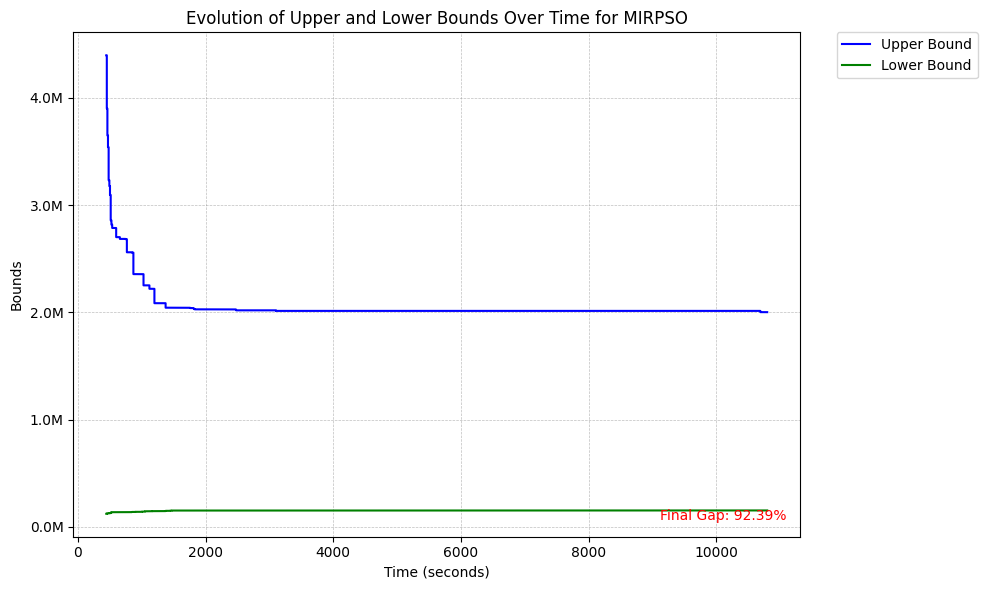

In [105]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Function to format the y-axis labels
def millions_formatter(x, pos):
    return f'{x / 1e6:.1f}M'

# Convert the data to a DataFrame
df = pd.DataFrame(bounds_history, columns=['Time', 'Upper Bound', 'Lower Bound', 'Gap'])

# Create a figure and a set of subplots
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the upper and lower bounds
sns.lineplot(x='Time', y='Upper Bound', data=df, ax=ax, color='blue', label='Upper Bound')
sns.lineplot(x='Time', y='Lower Bound', data=df, ax=ax, color='green', label='Lower Bound')

# Set the title and labels
plt.title('Evolution of Upper and Lower Bounds Over Time for MIRPSO')
ax.set_ylabel('Bounds')
ax.set_xlabel('Time (seconds)')

# Add a grid
ax.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.5)

# Set the y-axis label formatter
ax.yaxis.set_major_formatter(FuncFormatter(millions_formatter))

# Annotate the final gap
final_gap = df['Gap'].iloc[-1]  # Get the last gap value
plt.annotate(f'Final Gap: {final_gap:.2f}%', 
             xy=(1, 0), xycoords='axes fraction', 
             xytext=(-10, 10), textcoords='offset points',
             horizontalalignment='right',
             verticalalignment='bottom',
             fontsize=10, color='red')

# Adjust the legend to be outside the plot
ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0)

plt.tight_layout()
plt.show()


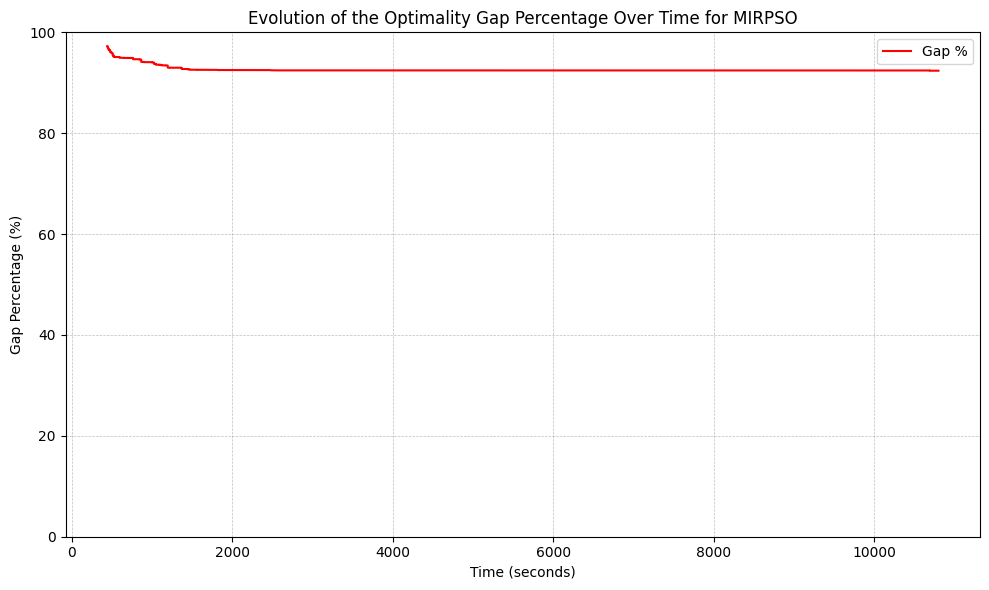

In [106]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Convert the data to a DataFrame
df = pd.DataFrame(bounds_history, columns=['Time', 'Upper Bound', 'Lower Bound', 'Gap'])

# Create a figure and a set of subplots
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the gap percentage over time
sns.lineplot(x='Time', y='Gap', data=df, ax=ax, color='red', label='Gap %')

# Set the title and labels
plt.title('Evolution of the Optimality Gap Percentage Over Time for MIRPSO')
ax.set_ylabel('Gap Percentage (%)')
ax.set_xlabel('Time (seconds)')

# Set y-axis limits from 0 to 100
ax.set_ylim(0, 100)

# Add a grid
ax.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.5)

# Adjust the legend
ax.legend(loc='upper right')

plt.tight_layout()
plt.show()


In [107]:
# For each vessel, save the route
vessel_routes_incl_wa = {}
for vessel in vessels:
    vessel_routes_incl_wa[vessel] = []
    for arc in vessel_arcs[vessel]:
        if x[arc.tuple, vessel].x > 0 + EBS:
            vessel_routes_incl_wa[vessel].append(arc)


In [108]:
vessel_routes = {}
for v in vessels:
    vessel_routes[v] = []
    for node in o_dict[v]:
        if node==sourceNode or node==sinkNode:
            continue
        if o[node.port.number, node.time, v].x > 0 + EBS:
            vessel_routes[v].append(node)

In [109]:
# Sort the arcs in each route by time
sequences = {}
for v in vessels:
    vessel_routes[v] = sorted(vessel_routes[v], key=lambda node: node.time)
    sequences[v] = [node.port.number for node in vessel_routes[v]]

In [110]:
sequences

{Vessel 1: [1, 4, 3],
 Vessel 2: [4, 1, 5, 4, 3],
 Vessel 3: [5, 1],
 Vessel 5: [1, 4, 5, 1],
 Vessel 7: [3, 1, 5, 4, 3],
 Vessel 8: [1, 3, 1],
 Vessel 9: [1, 5, 1],
 Vessel 10: [1, 4, 3]}

In [111]:
# Sort the arcs in each route by time
for vessel in vessels:
    vessel_routes_incl_wa[vessel] = sorted(vessel_routes_incl_wa[vessel], key=lambda x: x.origin_node.time)

In [112]:
# For each vessel, save the route, but only the port-sequence
vessel_routes_seq = {}
for vessel in vessels:
    vessel_routes_seq[vessel] = []
    for arc in vessel_arcs[vessel]:
        if arc in waiting_arcs[vessel]:
            continue
        if x[arc.tuple, vessel].x > 0 + EBS:
            vessel_routes_seq[vessel].append(arc.destination_node.port.number)
vessel_routes_seq

{Vessel 1: [1, 4, 3, 6],
 Vessel 2: [4, 1, 5, 4, 3, 6],
 Vessel 3: [5, 1, 6],
 Vessel 5: [1, 4, 5, 1, 6],
 Vessel 7: [3, 1, 5, 4, 3, 6],
 Vessel 8: [1, 3, 1, 6],
 Vessel 9: [1, 5, 1, 6],
 Vessel 10: [1, 4, 3, 6]}

In [113]:
def visualize_solution_for_vessel(vessel, vessel_arcs):
    # Create a directed graph
    G = nx.DiGraph()

    # Add nodes to the graph
    for node in NODES:
        G.add_node(str(node.tuple))

    # Add edges (arcs) to the graph
    for arc in vessel_arcs[vessel]:
        G.add_edge(str(arc.origin_node.tuple), str(arc.destination_node.tuple))

    # Determine nodes with incoming and outgoing arcs
    nodes_with_incoming_arcs = [node for node, degree in G.in_degree() if degree > 0]
    nodes_with_outgoing_arcs = [node for node, degree in G.out_degree() if degree > 0]

   # Create a list to hold node colors
    node_colors = []
    for node_str in G.nodes():
        port_number, time = eval(node_str)  # Extract port number and time from the node label
        o_value = o.get((port_number, time, vessel))  # Use .get() to safely access the dictionary
        if o_value and o_value.x > 0 + EBS:
            node_colors.append('brown')  # Color for nodes with non-zero q values
        elif node_str in nodes_with_incoming_arcs or node_str in nodes_with_outgoing_arcs:
            node_colors.append('green')  # Color for nodes with arcs
        
        else:
            node_colors.append('skyblue')  # Default color for nodes without arcs or q values


    # Resetting the y_offset and y_spacing
    y_offset = 10
    y_spacing = -30  # Increase vertical spacing for better clarity

    # Manually specify the positions for each node
    pos = {}
    for node_str in G.nodes():
        port_number, time = eval(node_str)  # Extract port number and time from the node label
        # The x-coordinate is based on time, the y-coordinate is fixed for nodes with the same port
        pos[node_str] = (time * 10, port_number * y_spacing)  # Multiplying time by 10 for better horizontal spacing

    # Drawing the graph using the adjusted positions
    plt.figure(figsize=(15, 10))
    nx.draw(G, pos, with_labels=True, node_size=2000, node_color=node_colors, font_size=10)
    labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
    plt.title(f"Nodes and Arcs Graph for {vessel}")
    plt.show()

### VISUALIZE SOLUTION

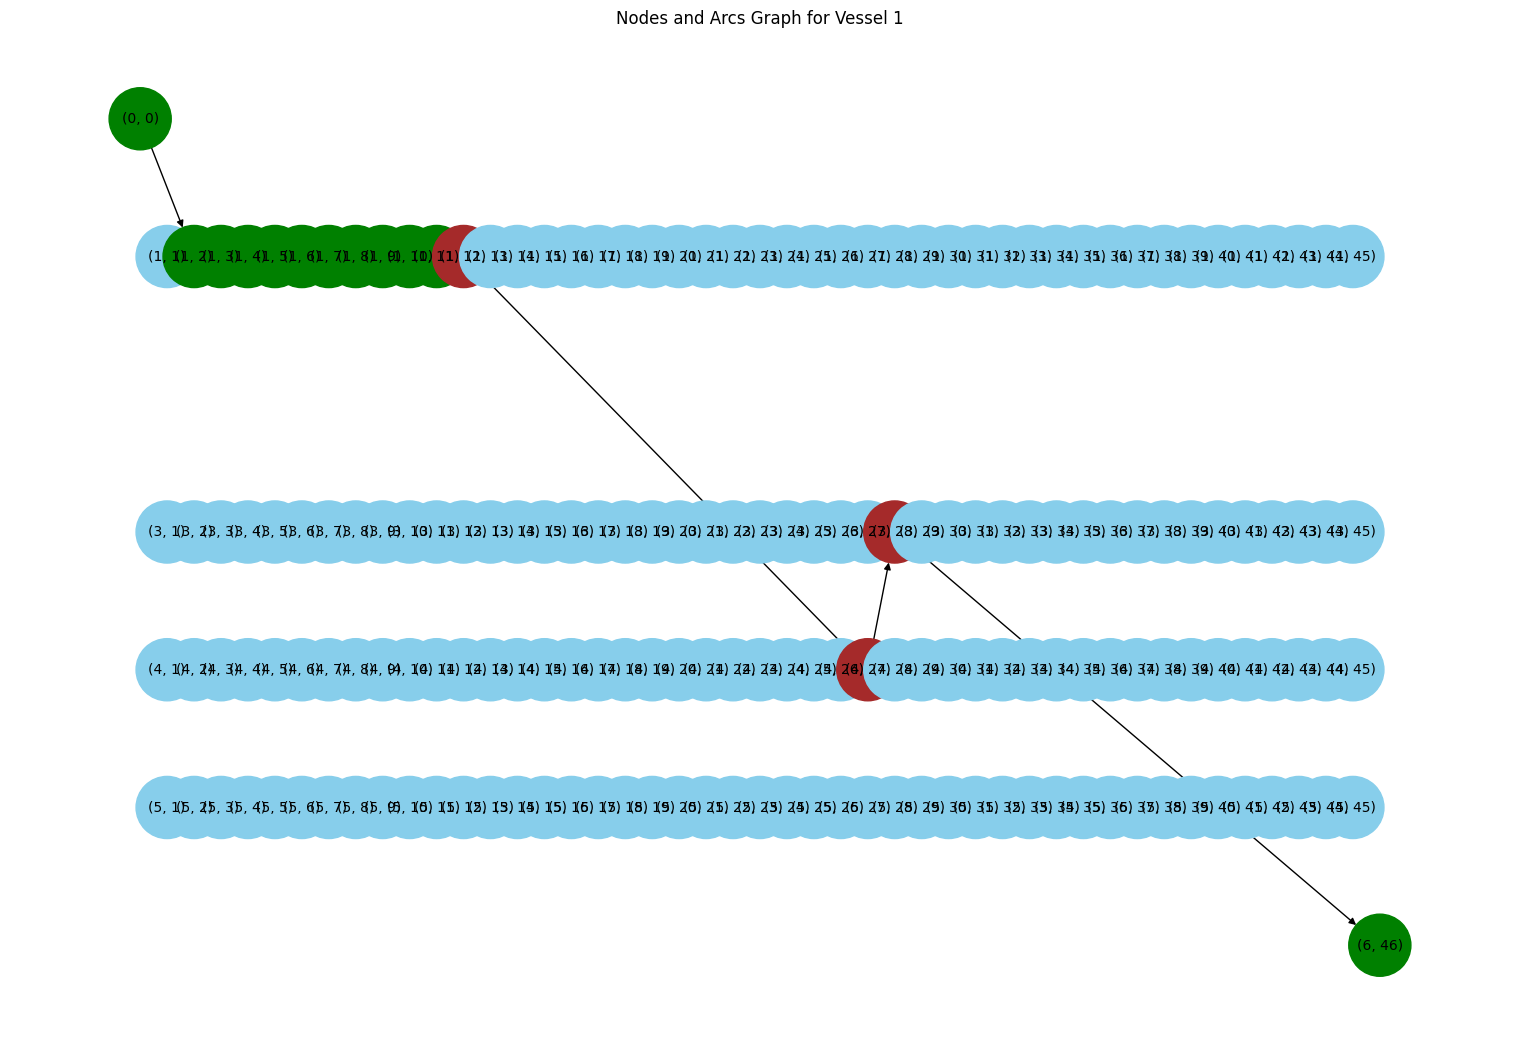

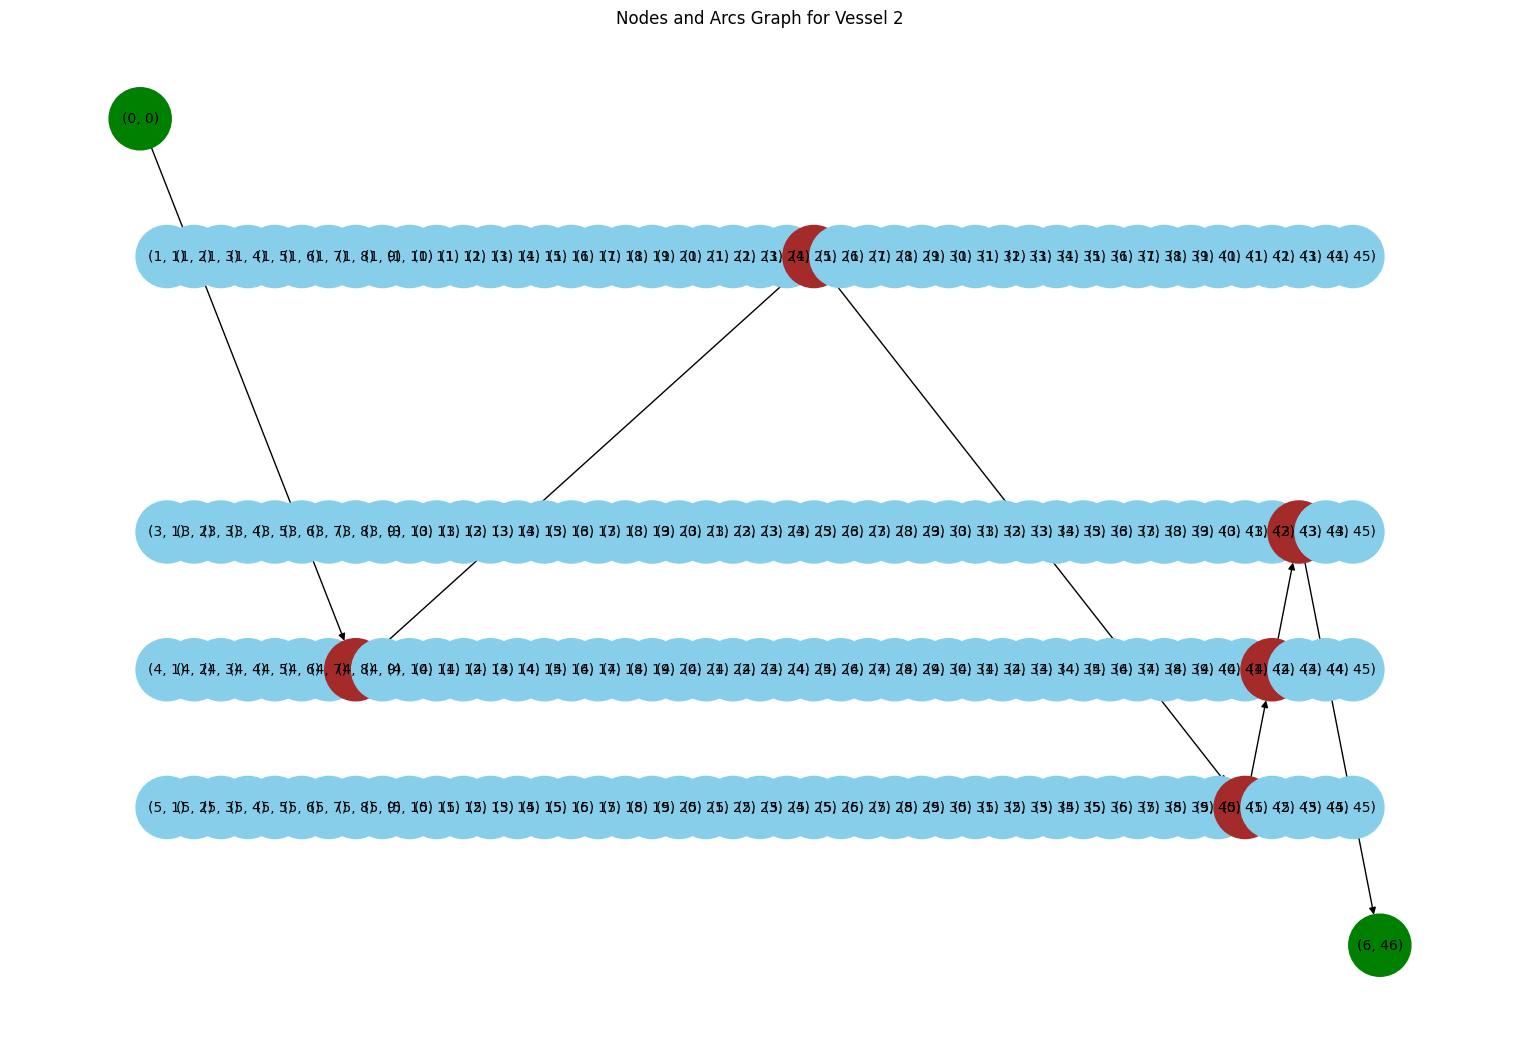

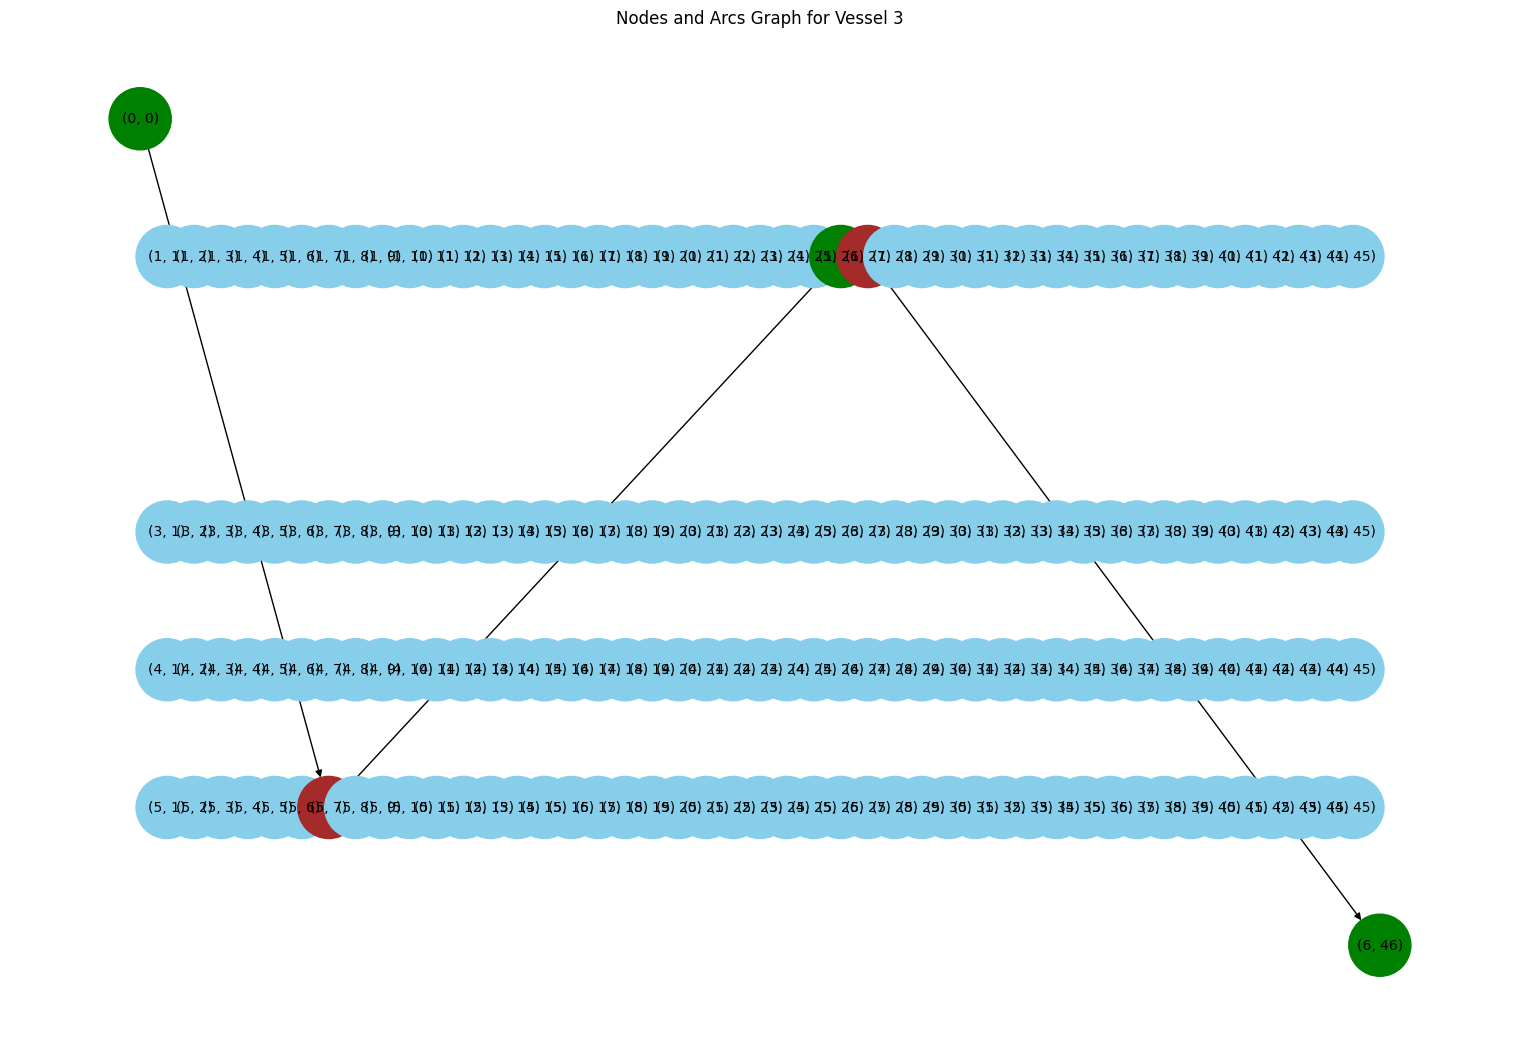

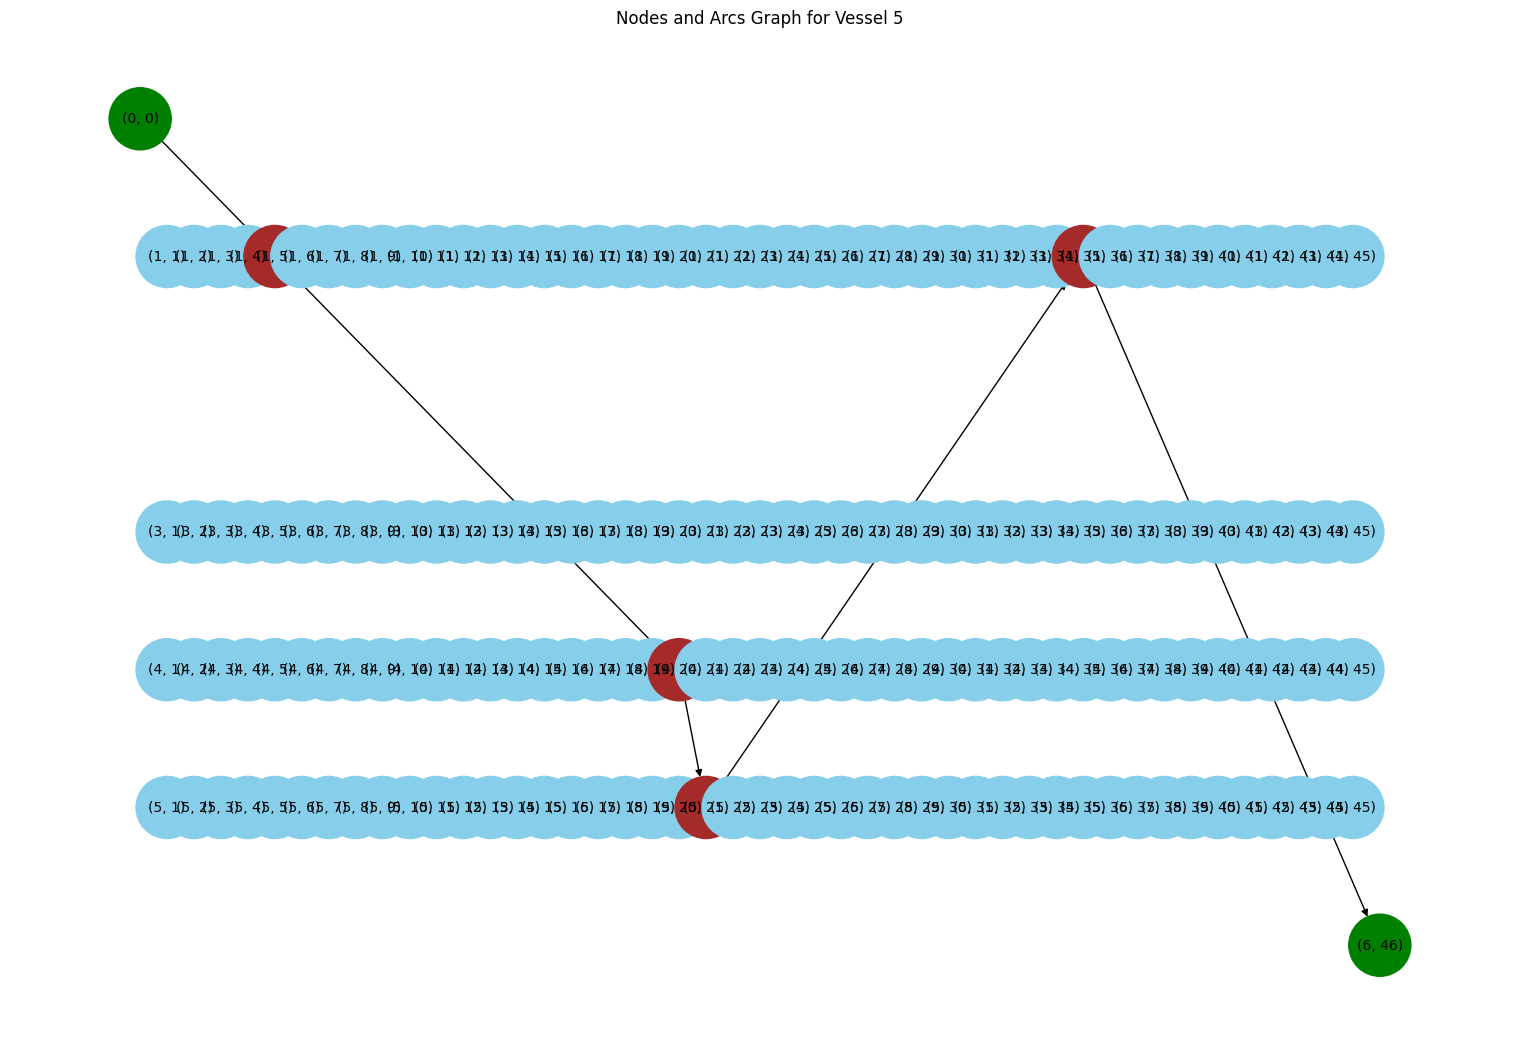

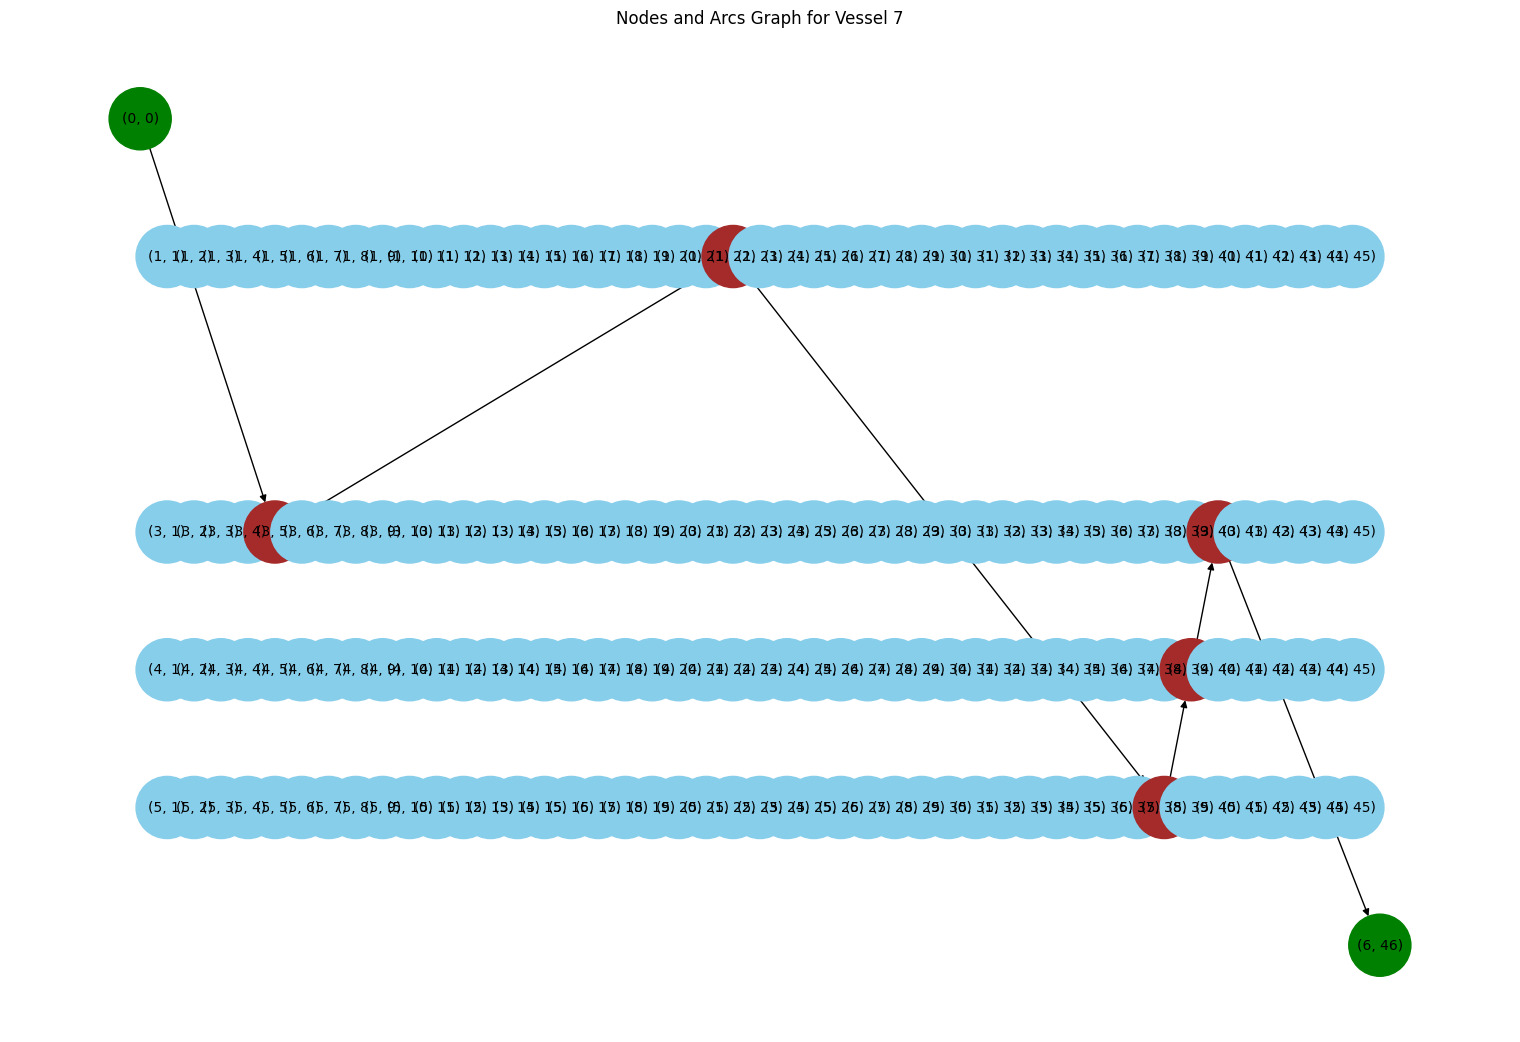

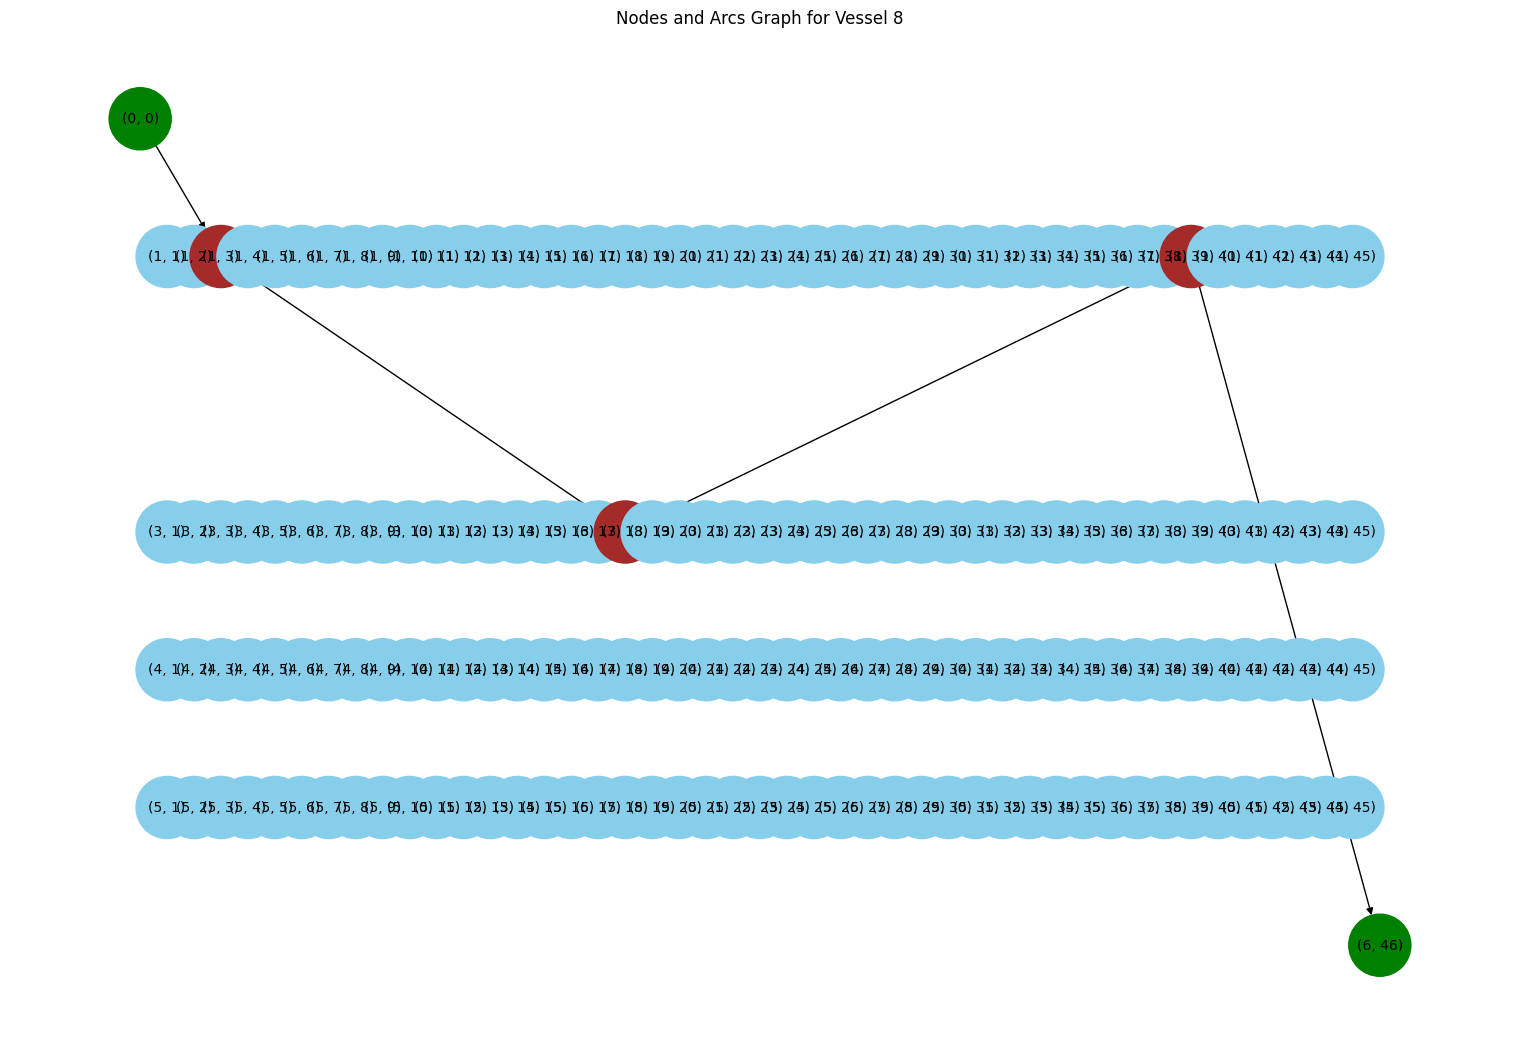

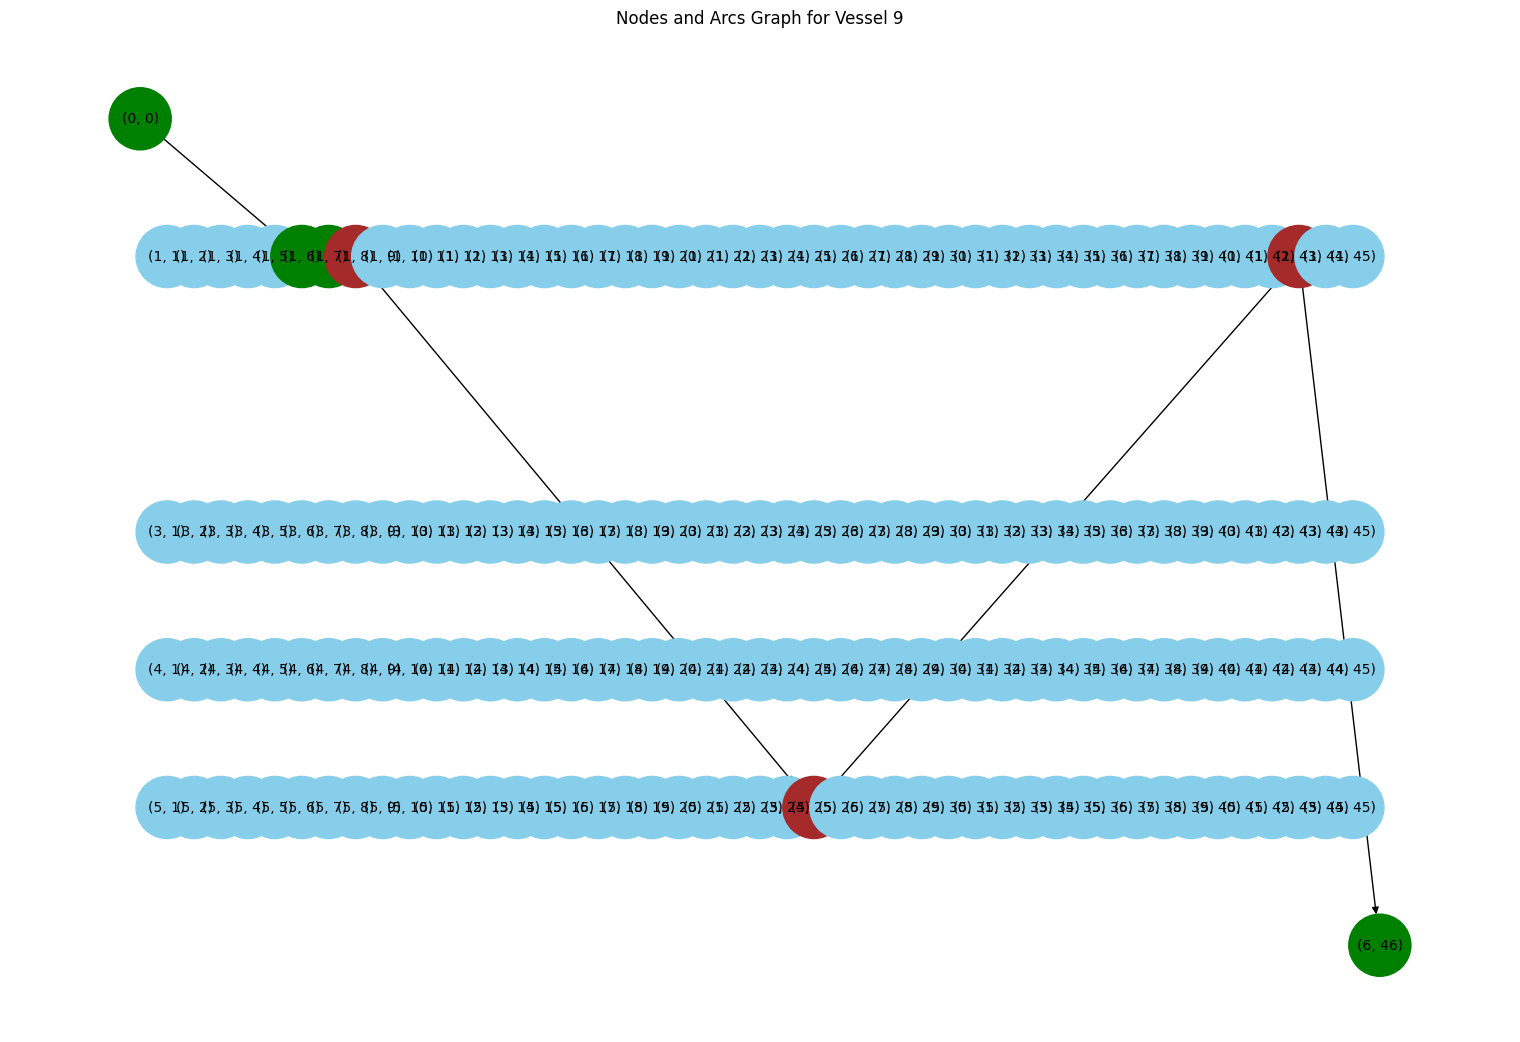

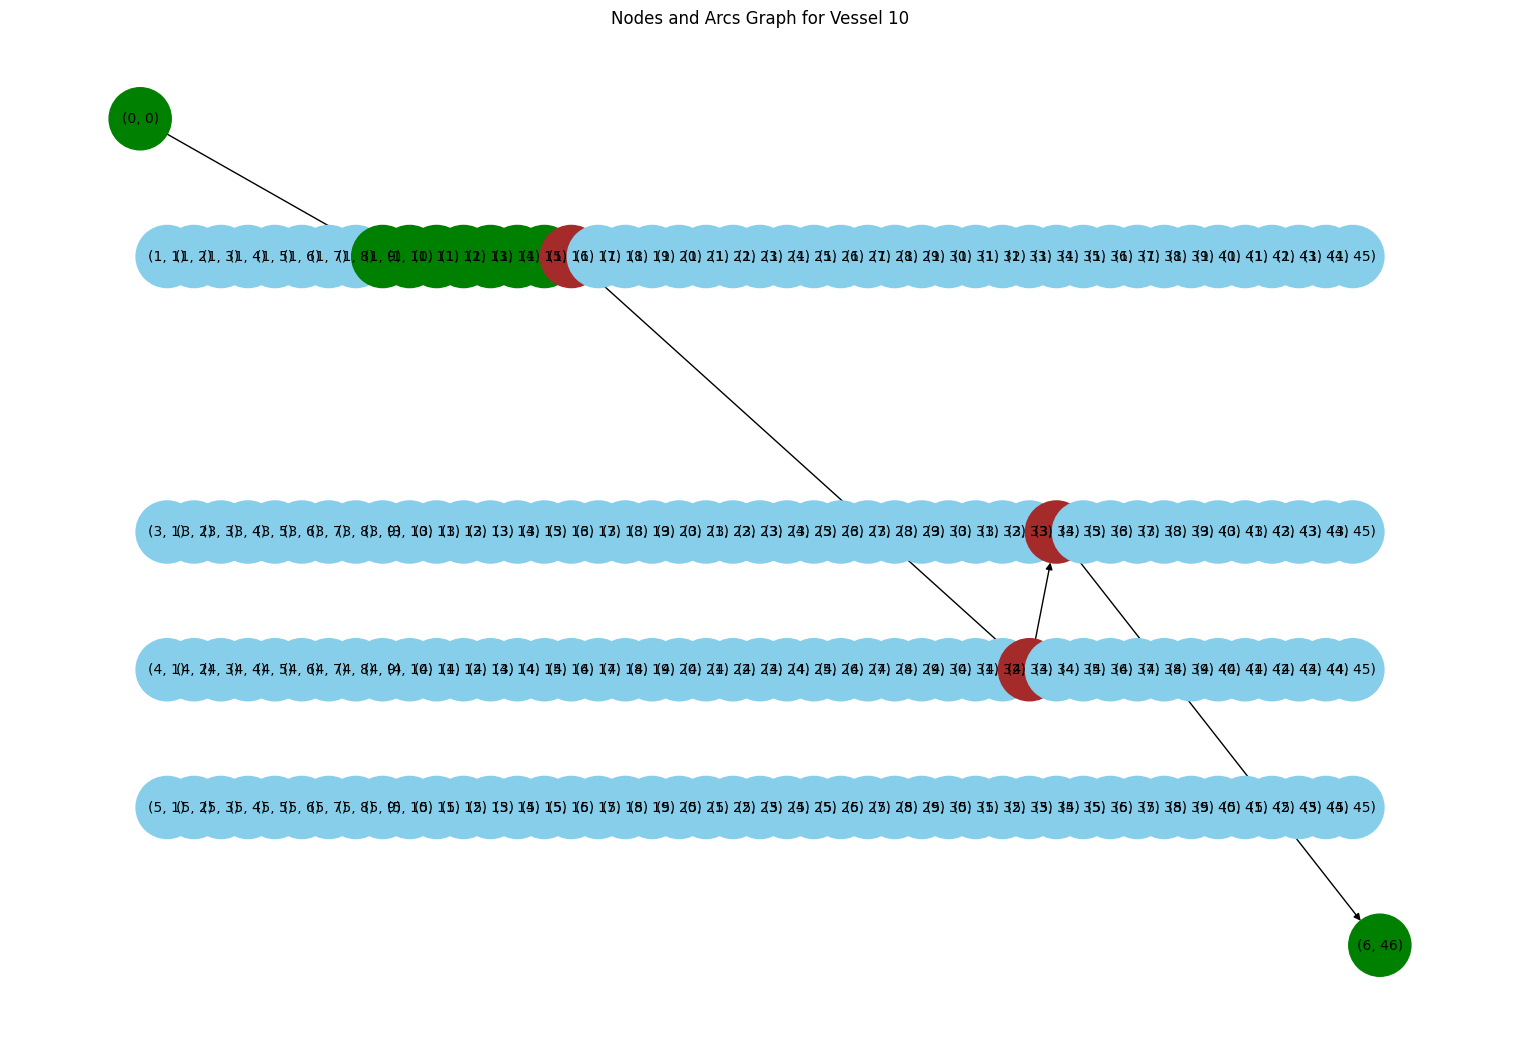

In [114]:
for v in vessels:
    visualize_solution_for_vessel(v, vessel_routes_incl_wa)

In [115]:
# Print the o vars
for v in vessels:
    for node in o_dict[v]:
        if o[node.port.number, node.time, v].x > 0 + EBS:
            print(o[node.port.number, node.time, v].varName, o[node.port.number, node.time, v].x)

o[1,12,Vessel 1] 1.0
o[4,27,Vessel 1] 1.0
o[3,28,Vessel 1] 1.0
o[4,8,Vessel 2] 1.0
o[1,25,Vessel 2] 1.0
o[5,41,Vessel 2] 1.0
o[4,42,Vessel 2] 1.0
o[3,43,Vessel 2] 1.0
o[5,7,Vessel 3] 1.0
o[1,27,Vessel 3] 1.0
o[1,5,Vessel 5] 1.0
o[4,20,Vessel 5] 1.0
o[5,21,Vessel 5] 1.0
o[1,35,Vessel 5] 1.0
o[3,5,Vessel 7] 1.0
o[1,22,Vessel 7] 1.0
o[5,38,Vessel 7] 1.0
o[4,39,Vessel 7] 1.0
o[3,40,Vessel 7] 1.0
o[1,3,Vessel 8] 1.0
o[3,18,Vessel 8] 1.0
o[1,39,Vessel 8] 1.0
o[1,8,Vessel 9] 1.0
o[5,25,Vessel 9] 1.0
o[1,43,Vessel 9] 1.0
o[1,16,Vessel 10] 1.0
o[4,33,Vessel 10] 1.0
o[3,34,Vessel 10] 1.0


In [116]:
# Print the q vars
for v in vessels:
    for node in o_dict[v]:
        if q[node.port.number, node.time, v].x > 0 + EBS:
            print(q[node.port.number, node.time, v].varName, q[node.port.number, node.time, v].x)

q[1,12,Vessel 1] 300.0
q[4,27,Vessel 1] 142.99999999999977
q[3,28,Vessel 1] 157.0000000000001
q[4,8,Vessel 2] 300.0
q[1,25,Vessel 2] 300.0
q[5,41,Vessel 2] 109.0
q[4,42,Vessel 2] 75.0
q[3,43,Vessel 2] 87.0
q[5,7,Vessel 3] 300.0
q[1,27,Vessel 3] 263.0
q[1,5,Vessel 5] 300.0
q[4,20,Vessel 5] 209.00000000000023
q[5,21,Vessel 5] 90.99999999999977
q[1,35,Vessel 5] 300.0
q[3,5,Vessel 7] 300.0
q[1,22,Vessel 7] 300.0
q[5,38,Vessel 7] 75.0
q[4,39,Vessel 7] 141.0
q[3,40,Vessel 7] 84.0
q[1,3,Vessel 8] 296.9999999999998
q[3,18,Vessel 8] 296.9999999999998
q[1,39,Vessel 8] 300.0
q[1,8,Vessel 9] 299.0000000000002
q[5,25,Vessel 9] 299.0
q[1,43,Vessel 9] 300.0
q[1,16,Vessel 10] 300.0
q[4,33,Vessel 10] 123.0
q[3,34,Vessel 10] 177.0


In [117]:
# Print all x-vars that are 1
active_arcs = {}
for v in vessels:
    v_arcs_active = []
    for arc in vessel_arcs[v]:
        if x[arc.tuple, v].x > 0 + EBS:
            v_arcs_active.append(arc)
    active_arcs[v] = v_arcs_active

# LOG

In [118]:

def log(FILEPATH):
    # Open a file to write the results
    with open(FILEPATH, 'w') as file:
        file.write("INSTANCE\n")
        file.write(INSTANCE_PATH)
        file.write("\n\n")
        
        
        file.write("Hyperparameters:\n")
        file.write(f"Number of Time Periods: {NUM_TIME_PERIODS}\n")
        file.write(f"Time Period Range: {TIME_PERIOD_RANGE}\n")
        file.write(f"Original Number of Vessels: {ORIGINAL_NUM_VESSELS}\n")
        file.write(f"Number of Vessels: {NUM_VESSELS}\n")
        file.write(f"Max Speed: {MAX_SPEED}\n")
        file.write(f"Min Speed: {MIN_SPEED}\n")
        file.write(f"Operating Speed: {OPERATING_SPEED}\n")
        file.write(f"Operating Cost: {OPERATING_COST}\n")
        file.write(f"Waiting Cost: {WAITING_COST}\n")
        file.write(f"Fuel Price (USD/ton): {FUEL_PRICE}\n\n")
        file.write(f"Original number of ports: {ORIGINAL_NUM_PORTS}\n\n")
        file.write(f"Number of ports: {NUM_PORTS}\n\n")
        
        file.write("\nPorts:\n")
        for port in ports:
            file.write(f"{port.__repr2__()}\n")
            
        file.write("\nVessels:\n")
        for vessel in vessels:
            file.write(f"{vessel.__repr2__()}\n")
        
        file.write("\nFull distance matrix:\n")
        for row in FULL_DISTANCE_MATRIX:
            row_str = ', '.join([f"{item:.4f}" for item in row])  # Format each item in the row
            file.write(f"[{row_str}]\n")
            
        file.write("\n Start times:\n")
        for vessel in vessels:
            file.write(f"{vessel}: {start_times[vessel]}\n")
        file.write("\n")
        
        file.write("----------------------------------------\n")
        # Write the objective value
        file.write(f"Objective Value: {m.objVal}\n")    
        file.write("----------------------------------------\n")
        
        # Log the GAP
        file.write("\nOptimality Gap:\n")
        gap_percentage = m.MIPGap * 100  # Convert to percentage
        file.write(f"Current GAP: {gap_percentage:.2f}%\n")
        
        # Write the active arcs to file
        file.write("\nActive Arcs:\n")
        for vessel in vessels:
            file.write(f"{vessel}: {[arc for arc in active_arcs[vessel]]}\n")
        file.write("\n")
        
        # Write all arcs to the file
        file.write("\nAll Arcs:\n")
        for vessel in vessels:
            file.write(f"{vessel}: {[arc for arc in vessel_arcs[vessel]]}\n")
        file.write("\n")

        # Write the values of all variables
        file.write("Variable Values:\n")
        for var in m.getVars():
            file.write(f"{var.varName}: {var.x}\n")
            
        file.close()


In [119]:
if LOG:
   log(FILEPATH)